## Data Exploration (ML50-2023)

### __Importing libraries__

In [501]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from IPython.display import display_html


# -------------------------------------------------------------------------
# Imputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### __Importing data__

In [502]:
# Data path : ../Data/test.csv
test_path = os.path.join('..', 'Data', 'test.csv')
train_path = os.path.join('..', 'Data', 'train.csv')
icd_9_path = os.path.join('..', 'Data', 'icd9_codes.txt')

# Read data
test = pd.read_csv(test_path, index_col='encounter_id')
train = pd.read_csv(train_path, index_col='encounter_id')

# Read ICD-9 codes
icd_9 = pd.read_csv(icd_9_path, sep=',', encoding='ISO-8859-1', index_col=0)
icd_9['3 digit code'] = icd_9.index.str[:3]
icd_9.set_index('3 digit code', inplace=True)
icd_9 = icd_9[~icd_9.index.duplicated(keep='first')]

# Keep track of the ids of the test and training data
test_ids = test.index
train_ids = train.index

# Data will have to be treated as a whole, so we will concatenate the test and training data
data = pd.concat([train, test], axis=0)

### __Minor changes to the data__
- __Remove 0 variance columns__
- __Changing column names__
- __Binary encoding__
- __?, Not Mapped, Not Available as NaN__
- __Applying the changes to the test and train data__

__1. Removing 0 variance columns__

In [503]:
data = data.drop(['country'], axis=1)

__2. Changing column names__

In [504]:
mapper = {
    'outpatient_visits_in_previous_year': 'n_outvis',
    'inpatient_visits_in_previous_year': 'n_invis',
    'emergency_visits_in_previous_year': 'n_emvis',
    'change_in_meds_during_hospitalization': 'b_changeMeds',
    'prescribed_diabetes_meds': 'b_diabetesMeds',
    'length_of_stay_in_hospital': 'n_stay',
    'number_of_medications': 'n_meds',
    'primary_diagnosis': 'c_diag1',
    'secondary_diagnosis': 'c_diag2',
    'additional_diagnosis': 'c_diag3',
    'number_diagnoses': 'n_diag',
    'number_lab_tests': 'n_tests',
    'discharge_disposition': 'c_disp',
    'race' : 'c_race',
    'gender' : 'b_gender',
    'age' : 'c_age',
    'weight' : 'c_weight',
    'admission_type' : 'c_admission',
    'payer_code' : 'c_payer',
    'medical_specialty' : 'c_specialty',
    'glucose_test_result' : 'c_glu',
    'a1c_test_result' : 'c_a1c',
    'average_pulse_bpm' : 'n_pulse',
    'readmitted_binary' : 'b_target',
    'readmitted_multiclass' : 'c_target',
    'medication' : 'c_medication',
    'admission_source' : 'c_source',
    'non_lab_procedures' : 'n_nonLab',
    'patient_id' : 'c_patient',
}

data = data.rename(columns=mapper)
data.columns

Index(['c_patient', 'c_race', 'b_gender', 'c_age', 'c_weight', 'c_payer',
       'n_outvis', 'n_emvis', 'n_invis', 'c_admission', 'c_specialty',
       'n_pulse', 'c_disp', 'c_source', 'n_stay', 'n_tests', 'n_nonLab',
       'n_meds', 'c_diag1', 'c_diag2', 'c_diag3', 'n_diag', 'c_glu', 'c_a1c',
       'b_changeMeds', 'b_diabetesMeds', 'c_medication', 'b_target',
       'c_target'],
      dtype='object')

__3. Binary encoding__

In [505]:
binary_features = [col for col in data.columns if col.startswith('b_')]
data['b_gender'] = data['b_gender'].map({'Female' : 0, 'Male' : 1})
data['b_changeMeds'] = data['b_changeMeds'].map({'No' : 0, 'Ch' : 1})
data['b_diabetesMeds'] = data['b_diabetesMeds'].map({'No' : 0, 'Yes' : 1})
data['b_target'] = data['b_target'].map({'No' : 0, 'Yes' : 1})

data[binary_features]

,b_gender,b_changeMeds,b_diabetesMeds,b_target
encounter_id,,,,
533253,0.0,0,0,0.0
426224,1.0,0,1,0.0
634063,0.0,1,1,0.0
890610,1.0,0,0,0.0
654194,0.0,0,0,0.0
...,...,...,...,...
451150,1.0,0,0,NaN
549298,1.0,0,1,NaN
327586,0.0,0,1,NaN


__4. ?, Not Mapped, Not Available as NaN__

In [506]:
to_replace = ['?', 'Not Mapped', 'Not Available', ' Not Mapped']
data = data.replace(to_replace, np.nan)

__5. Applying the changes to the test and train data__

In [507]:
train = data.loc[train_ids]
test = data.loc[test_ids]

### __Changes in data__

In [508]:
from IPython.display import display, HTML

def var_report(column_name, data=data, train_ids=train_ids, test_ids=test_ids):
    # If some of the train_ids are not in the data, dont get an error
    train_ids = [idx for idx in train_ids if idx in data.index]
    test_ids = [idx for idx in test_ids if idx in data.index]
    train = data.loc[train_ids]
    test = data.loc[test_ids]
    
    train_counts = train[column_name].value_counts(dropna=False)
    test_counts = test[column_name].value_counts(dropna=False)
    train_counts_pct = round(100*train_counts / len(train[column_name]), 2)
    test_counts_pct = round(100*test_counts / len(test[column_name]), 2)

    # Append percentages to the test counts
    test_counts = pd.concat([test_counts, test_counts_pct], axis=1)

    # For train, add the correlation with the target
    group = round(train.groupby(column_name, dropna=False)['b_target'].mean(),3)
    train_counts = pd.merge(train_counts, group, left_index=True, right_index=True)
    train_counts = pd.merge(train_counts, train_counts_pct, left_index=True, right_index=True)

    # Rename columns
    train_counts.columns = ['count', 'target_mean', 'percentage']
    test_counts.columns = ['count', 'percentage']

    # Adding the distance in percentage to the weighted mean
    weighted_mean = np.dot(train_counts['target_mean'], train_counts['count']) / train_counts['count'].sum()
    train_counts['distance (%)'] = round(100*((train_counts['target_mean'] - weighted_mean) / weighted_mean),2)

    # Convert to html
    train_counts_html = train_counts.to_html()
    test_counts_html = test_counts.to_html()

    # Calculate missing values and their percentage
    train_missing = train[column_name].isna().sum()
    test_missing = test[column_name].isna().sum()
    train_missing_pct = round(100*train_missing/len(train[column_name]), 2)
    test_missing_pct = round(100*test_missing/len(test[column_name]), 2)

    # Format the missing values and their percentage as strings
    train_missing_str = "{} ({:.2f}%)".format(train_missing, train_missing_pct)
    test_missing_str = "{} ({:.2f}%)".format(test_missing, test_missing_pct)

    # Create a histplot for the column with the target as hue
    fig, axis = plt.subplots(1, 2, figsize=(15, 5))
    train_counts_ordered = train_counts.sort_values(by='target_mean', ascending=False)
    train_counts_ordered.index = train_counts_ordered.index.astype(str)
    sns.barplot(x=train_counts_ordered.index, data=train_counts_ordered, y='distance (%)', ax=axis[0])
    sns.barplot(x=train_counts_ordered.index, data=train_counts_ordered, y='count', ax=axis[1])

    # Rotate the xticks
    axis[0].tick_params(axis='x', rotation=90)
    axis[1].tick_params(axis='x', rotation=90)

    # If there are more than 25 categories, dont show the labels
    if len(train_counts) > 20:
        axis[0].tick_params(axis='x', labelsize=0)
        axis[1].tick_params(axis='x', labelsize=0)
    # Set the title
    axis[0].set_title('Proportion of target in {}'.format(column_name))
    axis[1].set_title('Distribution of {}'.format(column_name))

    display(HTML(f"""
        <div style="display: flex; justify-content: space-between;">
            <div style="padding-right: 20px;">
                <h3>Value counts in train data:</h3>
                {train_counts_html}
            </div> 
            <div style="padding-right: 20px;">
                <h3>Value counts in test data:</h3>
                {test_counts_html}
            </div>
            <div>
                <h3>Missing values in train data:</h3>
                {train_missing_str}
                <h3>Missing values in test data:</h3>
                {test_missing_str}
            </div>
        </div>
    """))

# One hot encoding, avoid dummy trap
def one_hot_encode(data, column_name, drop_first=True):
    # Set dummy na to true so that we get a column for the missing values
    if data[column_name].isna().sum() > 0:
        data[column_name] = data[column_name].fillna('missing')
    dummies = pd.get_dummies(data[column_name], prefix=column_name, drop_first=drop_first, dtype=np.int8)
    # Change the names of the dummies so that they start with b_ instead of c_
    dummies.columns = ['b_' + col[2:] for col in dummies.columns]
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column_name, axis=1)
    return data

#### __1. Race__
__Modifications:__
- Will be imputed after the preprocessing and then one hot encoded
<br>

__Relevant Information:__
- 5 categories + NaN
- Other shows relevant counter information whilst caucasian has the highest amount of people with some positive information
__________________________________________

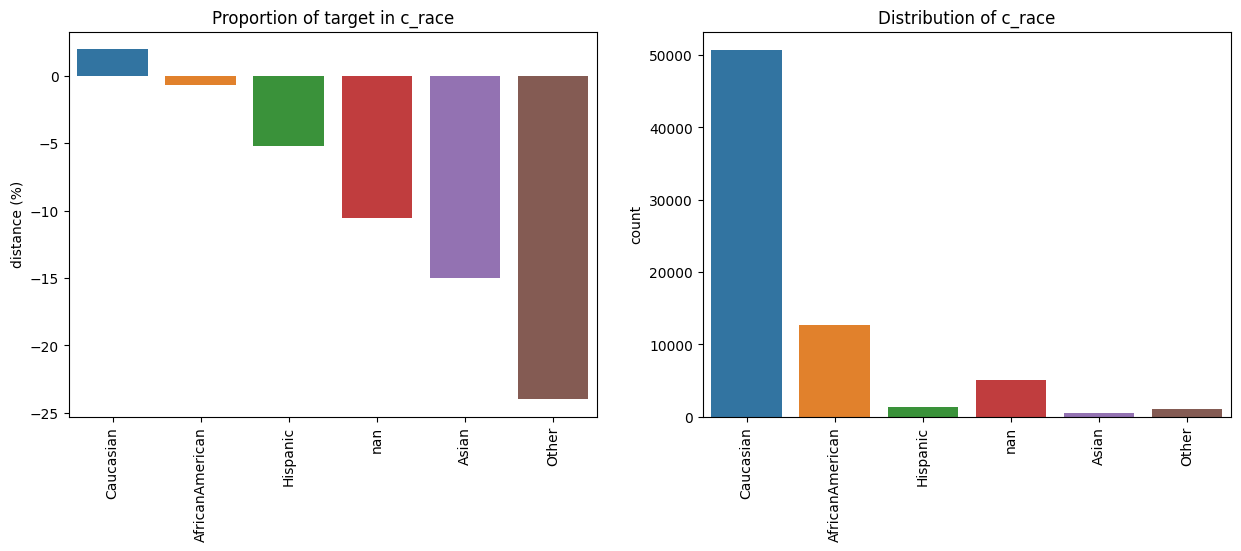

In [509]:
var_report('c_race', data)

#### __2. Gender__
__Modifications:__
- Droping the NaN values (<0.01%)
<br>

__Relevant Information:__
- Doesn't show relevant information
__________________________________________

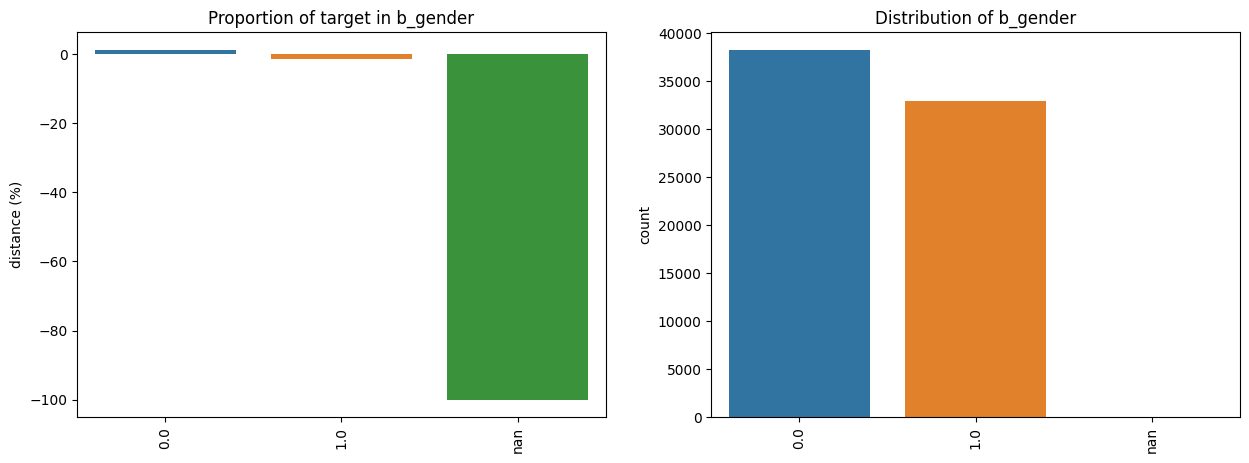

In [510]:
var_report('b_gender', data)

In [511]:
# Drop variables in train with a Nan gender
ids_to_drop = data[data.isna()['b_gender']].index
train = train.drop(ids_to_drop)
data = data[~data.isna()['b_gender']]

#### __3. Age__
__Modifications:__
- Considering the middle point of the age range
<br>

__Relevant Information:__
- Significant information for the model, especially for the age range 70-80 and 80-90, with a higher percentage of people readmitted and a large count of people in those age ranges
__________________________________________

,count,target_mean,percentage,distance (%)
[70-80),17357,0.118,24.37,5.56
[60-70),14907,0.109,20.93,-2.49
[80-90),11510,0.123,16.16,10.04
[50-60),11423,0.099,16.04,-11.44
[40-50),6418,0.105,9.01,-6.07
NaN,3557,0.110,4.99,-1.59
[30-40),2536,0.109,3.56,-2.49
[90-100),1875,0.117,2.63,4.67
[20-30),1071,0.142,1.50,27.03
[10-20),474,0.061,0.67,-45.43


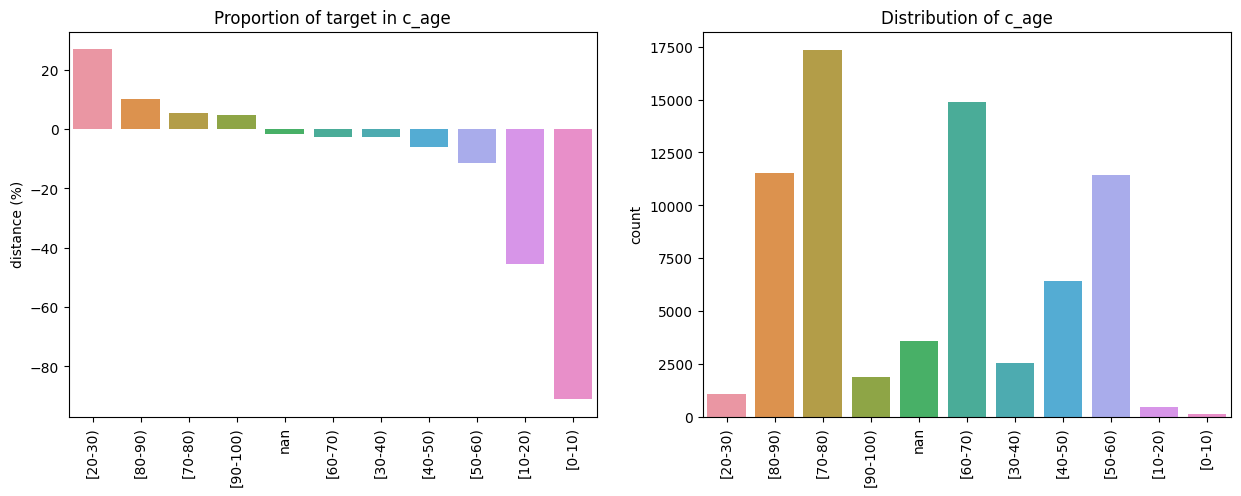

In [512]:
var_report('c_age', data)

In [513]:
age_dict = {'[0-10)': 5,
           '[10-20)': 15,
           '[20-30)': 25,
           '[30-40)': 35,
           '[40-50)': 45,
           '[50-60)': 55,
           '[60-70)': 65,
           '[70-80)': 75,
           '[80-90)': 85,
           '[90-100)': 95}

data['n_age'] = data['c_age'].map(age_dict)
data = data.drop('c_age', axis=1)

C:\Users\Mateus\AppData\Local\Temp\ipykernel_27224\2359468126.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n_age'] = data['c_age'].map(age_dict)


#### __4. Weight__
__Modifications:__
- Droping the column
- Creating a new column with the information if the patient was weighted or not
<br>

__Relevant Information:__
- Very little relevant information, with a large amount of missing values. 
__________________________________________

,count,target_mean,percentage,distance (%)
NaN,68987,0.112,96.85,0.10
[75-100),933,0.109,1.31,-2.58
[50-75),636,0.112,0.89,0.10
[100-125),449,0.111,0.63,-0.80
[125-150),96,0.052,0.13,-53.53
[25-50),67,0.104,0.09,-7.05
[0-25),35,0.171,0.05,52.83
[150-175),21,0.095,0.03,-15.10
[175-200),7,0.143,0.01,27.80
>200,2,0.000,0.00,-100.00


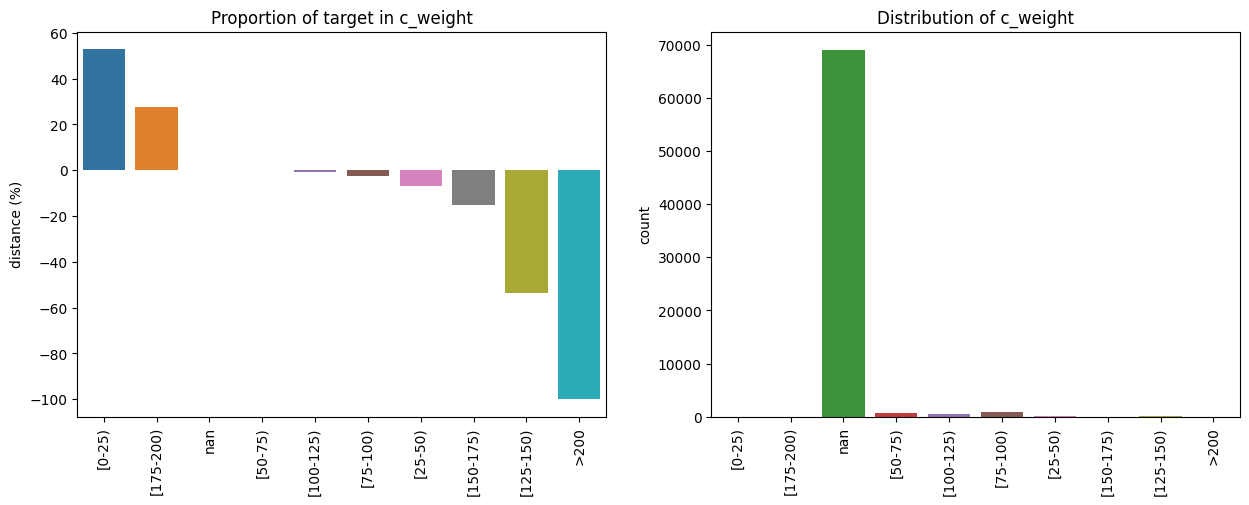

In [514]:
var_report('c_weight', data)

In [515]:
data['b_weight'] = data['c_weight'].notna().astype(np.int8)
data = data.drop('c_weight', axis=1)
print(data['b_weight'].value_counts(dropna=False))

0    98566
1     3197
Name: b_weight, dtype: int64


#### __5. Payer code__
__Modifications:__
- Creating a new c_payer column - $payerGroup$ - that is dimensionally reduced
- One hot encoding
<br>

__Relevant Information:__
- Lots of relevant information for the model. Altough there are a lot of missing values, missing values here probably indicate that the patient doesn't have an insurance plan, which is relevant information for the model
__________________________________________

,count,target_mean,percentage,distance (%)
NaN,28200,0.115,39.59,3.07
MC,22683,0.119,31.84,6.66
HM,4319,0.098,6.06,-12.16
SP,3541,0.101,4.97,-9.48
BC,3292,0.094,4.62,-15.75
MD,2484,0.125,3.49,12.04
CP,1760,0.090,2.47,-19.33
UN,1733,0.086,2.43,-22.92
CM,1347,0.088,1.89,-21.13
OG,729,0.115,1.02,3.07


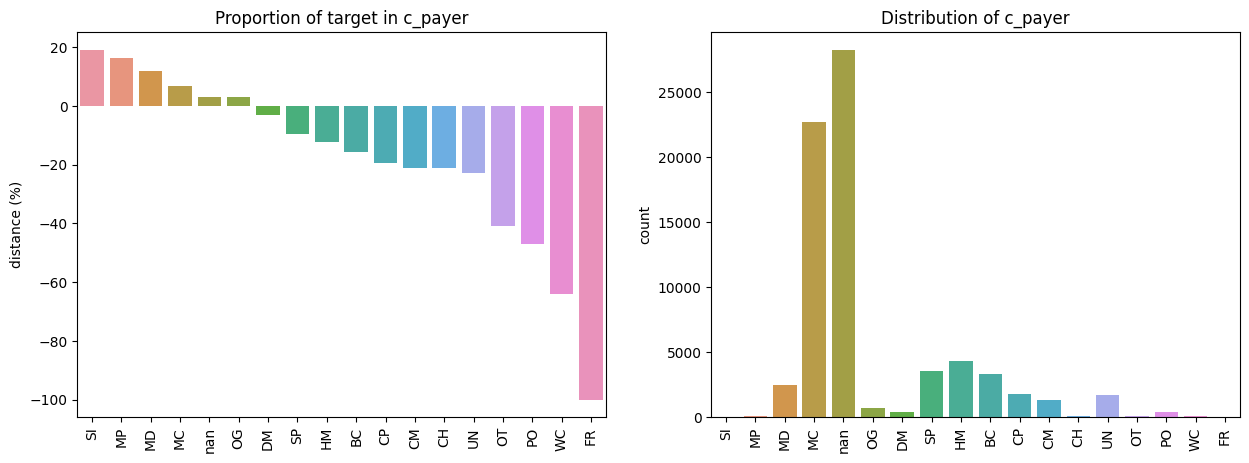

In [516]:
var_report('c_payer', data)

Creating payerGroup column

In [517]:
data['c_payer'].fillna('No', inplace=True)

data['c_payerGroup'] = data['c_payer'].map({
    'SI' : 'High',
    'MP' : 'High',
    'MD' : 'High',
    'MC' : 'Medium',
    'OG' : 'Medium',
    'No' : 'Medium',
    'DM' : 'Low',
    'SP' : 'Low',
    'HM' : 'Low',
    'BC' : 'Very Low',
    'CP' : 'Very Low',
    'UN' : 'Very Low',
    'CM' : 'Very Low',
    'PO' : 'Very Low',
    'CH' : 'Very Low',
    'WC' : 'Very Low',
    'OT' : 'Very Low',
    'FR' : 'Very Low',
})

In [518]:
# One hot encode the payer group
data = one_hot_encode(data, 'c_payerGroup', drop_first=False)
data = one_hot_encode(data, 'c_payer', drop_first=False)

#### __6. Out-/Em-/Invisits__
__Modifications:__
- Croping the outliers and grouping them in a specific bin (4,5,3), changing the threshold based on the variable in question
- Creating a n_visits column with the sum of the 3 variables, and n_visits_pure with the sum of the unclipped variables (last bin = 9). They have a sligthly different distribution, so we will keep both. Why did we clip at 9? So that we keep a linear relationship between the number of visits and the readmission rate mean (see plot below 6.4)
<br>

__Relevant Information:__
- It seems like this variable has relevant information for the model, with a higher percentage of people readmitted in the higher bins. 
- Unsatisfactory high amount of 0s, which can be changed by summing the 3 variables
__________________________________________

##### __6.0 Pure visits__
__Last bin = 9__

,count,target_mean,percentage,distance (%)
0,38986,0.081,54.73,-27.32
1,14031,0.114,19.70,2.28
2,7072,0.149,9.93,33.69
3,4109,0.156,5.77,39.97
4,2490,0.174,3.50,56.12
5,1418,0.179,1.99,60.60
6,920,0.228,1.29,104.57
7,629,0.237,0.88,112.64
8,397,0.252,0.56,126.10
9,294,0.293,0.41,162.89


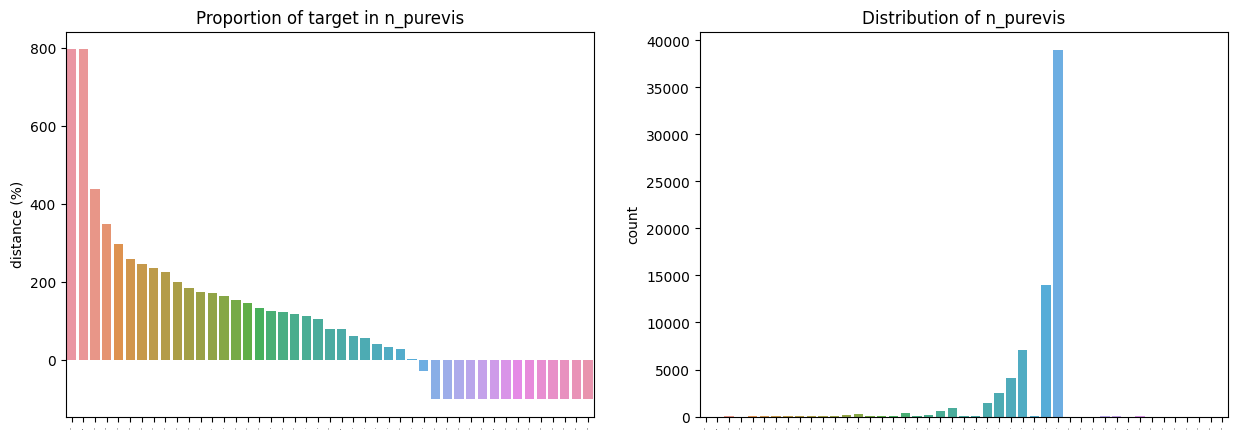

In [519]:
data['n_purevis'] = data['n_outvis'] + data['n_invis'] + data['n_emvis']
var_report('n_purevis', data)

In [520]:
data['n_purevis'] = data['n_purevis'].clip(upper=9)
data.value_counts('n_purevis')

n_purevis
0    55825
1    19941
2    10062
3     5904
4     3570
5     2036
9     1690
6     1313
7      868
8      554
dtype: int64

##### __6.1 Outvisits__
__Last bin = 4__

,count,target_mean,percentage,distance (%)
0,59584,0.106,83.65,-4.67
1,5967,0.142,8.38,27.71
2,2465,0.138,3.46,24.11
3,1431,0.125,2.01,12.42
4,760,0.154,1.07,38.50
5,370,0.111,0.52,-0.17
6,212,0.104,0.30,-6.47
7,107,0.168,0.15,51.09
8,67,0.030,0.09,-73.02
9,59,0.203,0.08,82.57


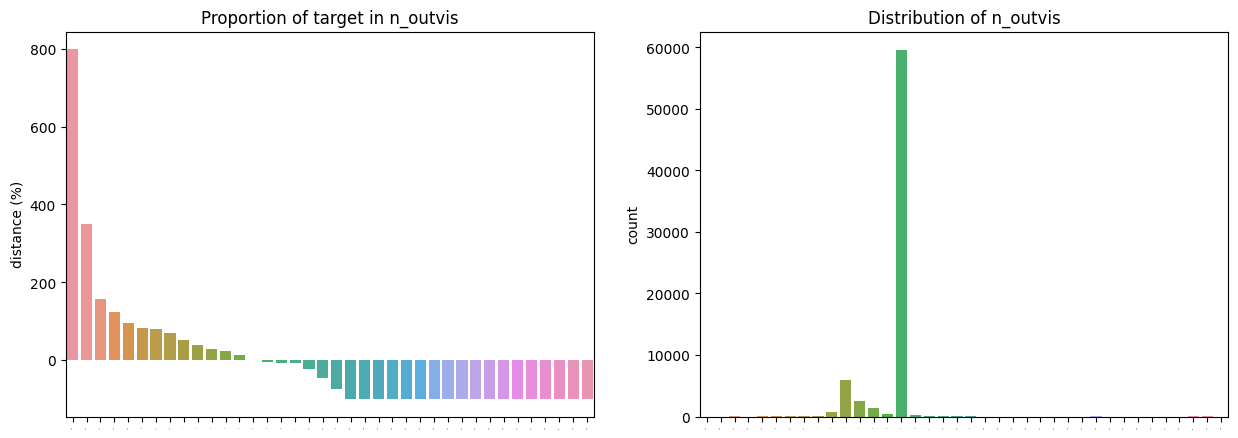

In [521]:
var_report('n_outvis', data)

In [522]:
# Values in n_outvis above 4 will be set to 4
data['n_outvis'] = data['n_outvis'].clip(upper=4)
data['n_outvis'].value_counts(dropna=False)

0    85024
1     8547
2     3594
4     2556
3     2042
Name: n_outvis, dtype: int64

##### __6.2 Invisits__
- __Last bin = 5__

,count,target_mean,percentage,distance (%)
0,47228,0.084,66.30,-24.72
1,13706,0.128,19.24,14.71
2,5303,0.175,7.44,56.82
3,2407,0.210,3.38,88.19
4,1159,0.240,1.63,115.07
5,553,0.300,0.78,168.84
6,361,0.357,0.51,219.92
7,195,0.364,0.27,226.20
8,109,0.486,0.15,335.52
9,81,0.407,0.11,264.73


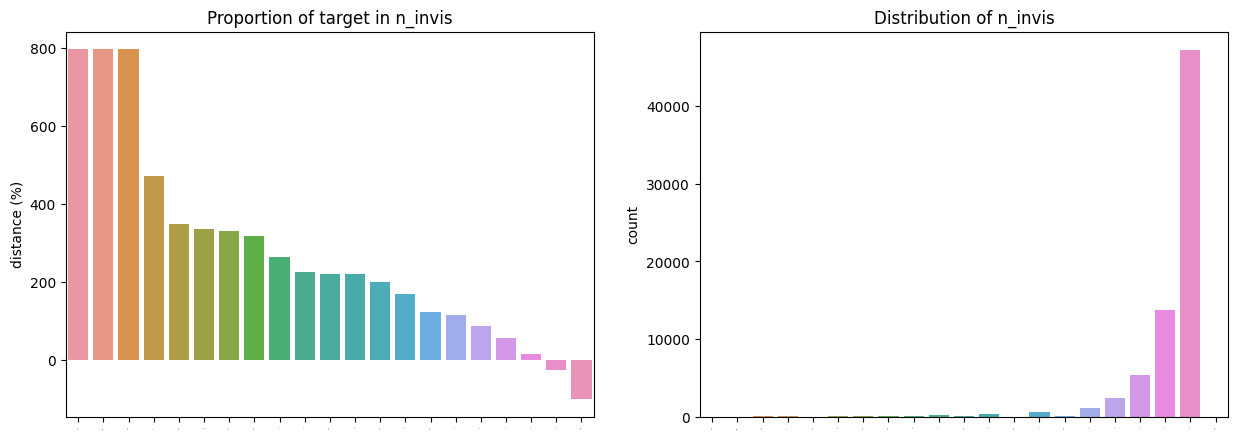

In [523]:
var_report('n_invis', data)

In [524]:
data['n_invis'] = data['n_invis'].clip(upper=5)
data['n_invis'].value_counts(dropna=False)

0    67627
1    19521
2     7566
3     3411
5     2016
4     1622
Name: n_invis, dtype: int64

##### __6.3 Emvisits__
- __Last bin = 3__

,count,target_mean,percentage,distance (%)
0,63239,0.105,88.78,-6.03
1,5422,0.142,7.61,27.08
2,1432,0.187,2.01,67.35
3,502,0.193,0.70,72.72
4,262,0.324,0.37,189.96
5,126,0.238,0.18,113.00
6,71,0.225,0.10,101.36
7,47,0.234,0.07,109.42
10,24,0.375,0.03,235.60
8,23,0.391,0.03,249.92


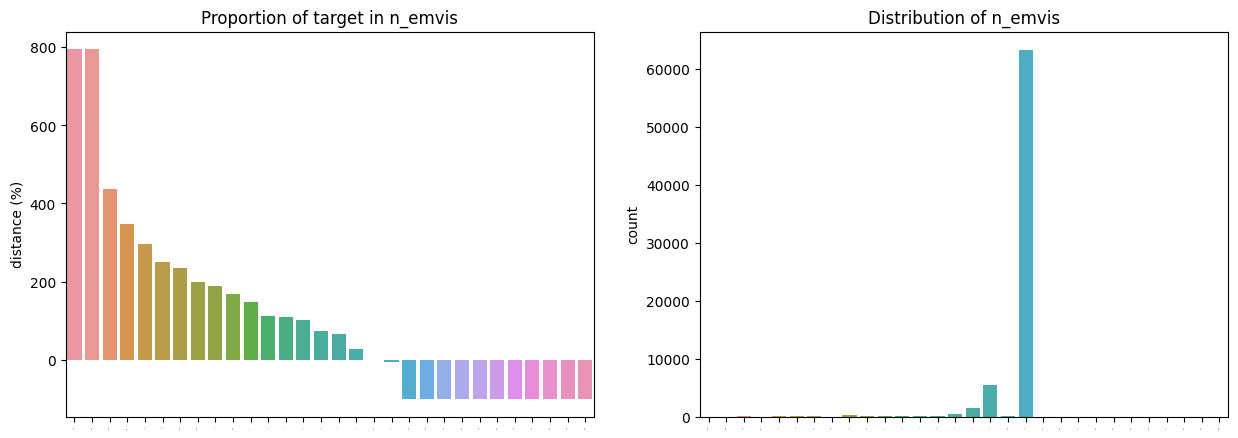

In [525]:
var_report('n_emvis', data)

In [526]:
data['n_emvis'] = data['n_emvis'].clip(upper=3)
data['n_emvis'].value_counts(dropna=False)

0    90380
1     7677
2     2042
3     1664
Name: n_emvis, dtype: int64

##### __6.4 Total visits__
- __Last bin = 9__

,count,target_mean,percentage,distance (%)
0,38986,0.081,54.73,-27.31
1,14031,0.114,19.70,2.31
2,7072,0.149,9.93,33.72
3,4168,0.155,5.85,39.11
4,2905,0.165,4.08,48.08
5,1833,0.207,2.57,85.77
6,981,0.250,1.38,124.37
7,561,0.257,0.79,130.65
8,393,0.305,0.55,173.73
9,163,0.374,0.23,235.65


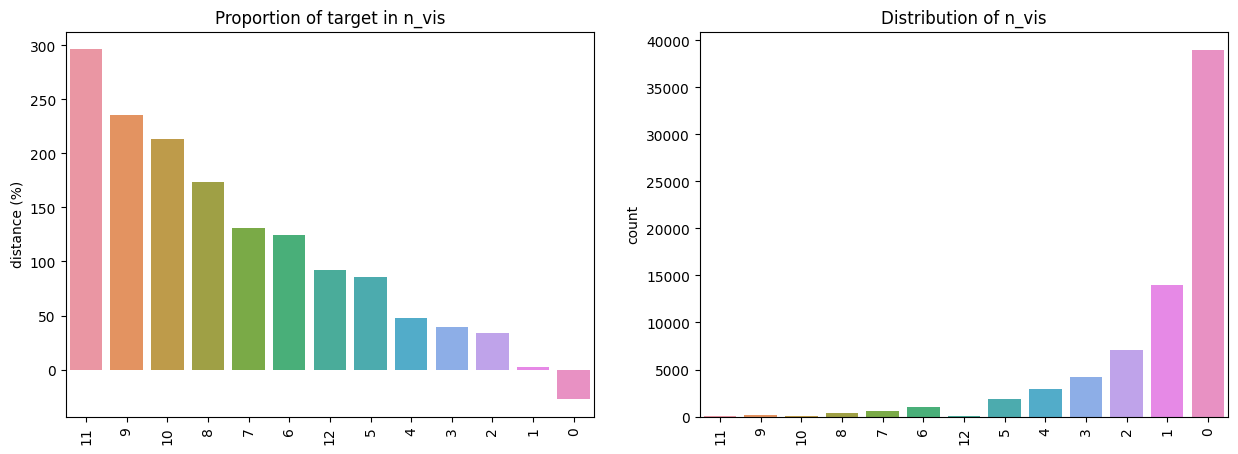

In [527]:
data['n_vis'] = data['n_outvis'] + data['n_invis'] + data['n_emvis']
var_report('n_vis', data)

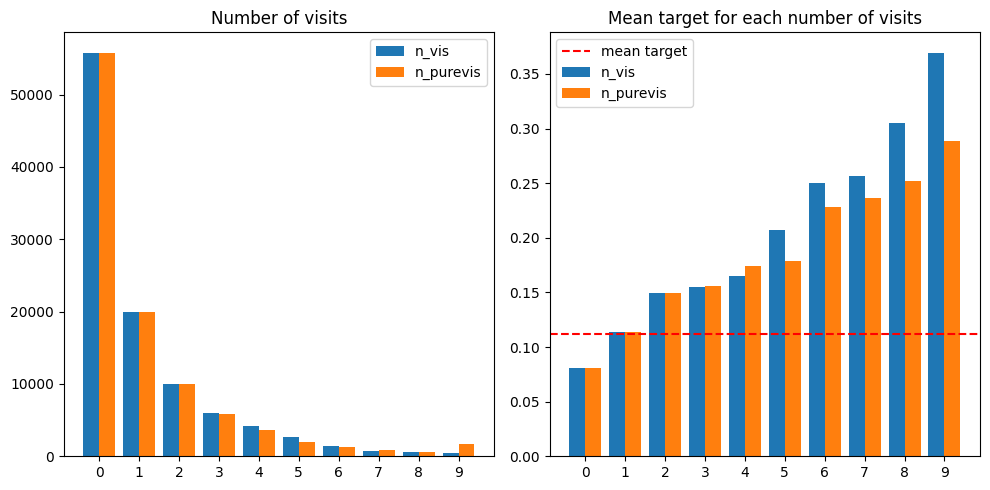

In [528]:
data['n_vis'] = data['n_vis'].clip(upper=9)
tab_vis = data['n_vis'].value_counts(dropna=False)
tab_vis = pd.concat([tab_vis, data['n_purevis'].value_counts(dropna=False)], axis=1)
tab_vis.columns = ['n_vis', 'n_purevis']

# Plot the distribution of the number of visits on the same graph
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
width = 0.4
ax[0].bar(tab_vis.index, tab_vis['n_vis'], width=width, label='n_vis')
ax[0].bar(tab_vis.index+width, tab_vis['n_purevis'], width=width, label='n_purevis')
ax[0].set_title('Number of visits')
ax[0].set_xticks(tab_vis.index + width / 2)
ax[0].set_xticklabels(tab_vis.index)
# Set the legend
ax[0].legend()

# Plot the mean target for each number of visits
ax[1].bar(tab_vis.index, data.groupby('n_vis')['b_target'].mean(), width=width, label='n_vis')
ax[1].bar(tab_vis.index+width, data.groupby('n_purevis')['b_target'].mean(), width=width, label='n_purevis')
ax[1].set_title('Mean target for each number of visits')
ax[1].set_xticks(tab_vis.index + width / 2)
ax[1].axhline(data['b_target'].mean(), color='red', label='mean target', linestyle='--')
ax[1].set_xticklabels(tab_vis.index)
# Set the legend
ax[1].legend()

plt.tight_layout()
plt.show()

#### __7. Admission Type__
__Modifications:__
- One hot encoding
<br>

__Relevant Information:__
- Emergency admissions have a higher percentage of people readmitted, which is relevant information for the model. Urgent as well, but much less than emergency
__________________________________________

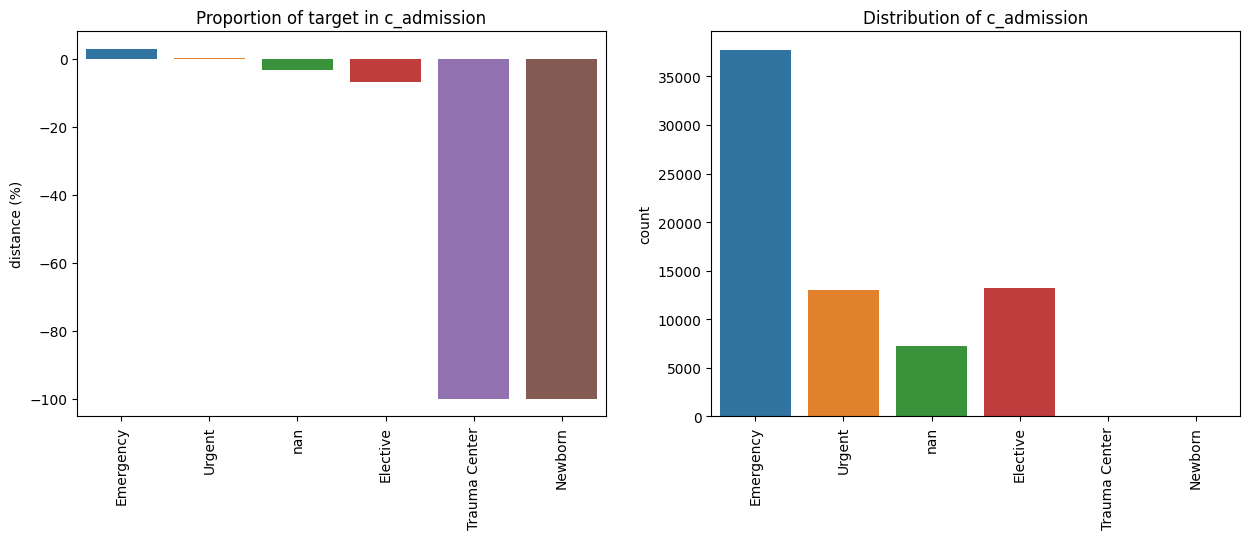

In [529]:
var_report('c_admission', data)

In [530]:
# Group Trauma Center and Newborn into Other
data['c_admission'] = data['c_admission'].replace({'Trauma Center' : 'Other', 'Newborn' : 'Other'})
data = one_hot_encode(data, 'c_admission', drop_first=False).drop('b_admission_Other', axis=1)

#### __8. Medical Specialty__
__Modifications:__
- Creating 8 groups based on the target mean
- One hot encoding the groups (too many values to impute the nan values, so lets just leave it as it is inside a separate group)
<br>

__Relevant Information:__
- Some relevant information for the model, with a higher percentage of people readmitted in some groups with high counts
__________________________________________

,count,target_mean,percentage,distance (%)
NaN,34920,0.116,49.02,3.84
InternalMedicine,10292,0.112,14.45,0.26
Emergency/Trauma,5319,0.113,7.47,1.16
Family/GeneralPractice,5217,0.117,7.32,4.74
Cardiology,3715,0.079,5.22,-29.28
Surgery-General,2144,0.115,3.01,2.95
Nephrology,1136,0.157,1.59,40.54
Orthopedics,954,0.101,1.34,-9.59
Orthopedics-Reconstructive,867,0.080,1.22,-28.39
Radiologist,817,0.086,1.15,-23.01


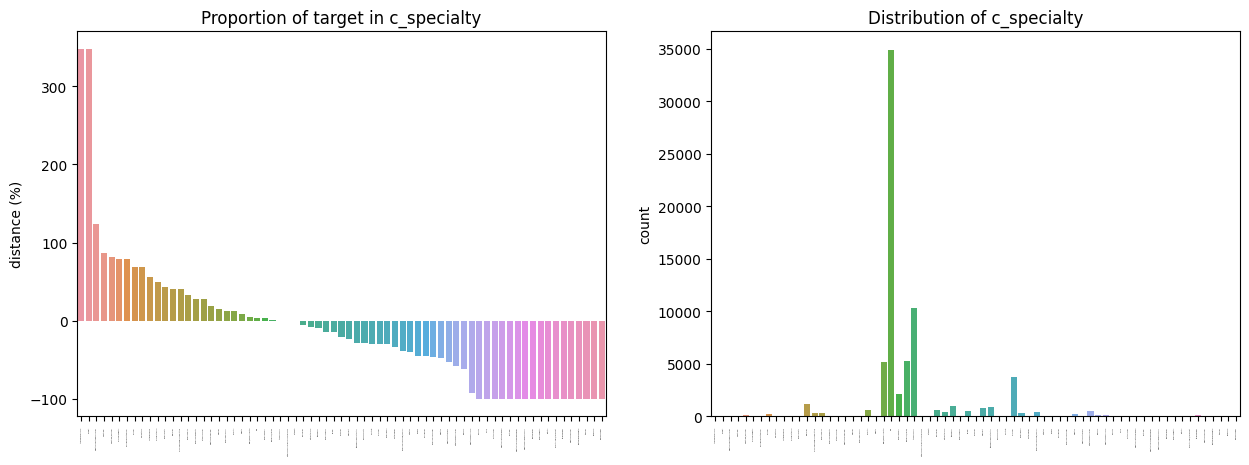

In [531]:
var_report('c_specialty', data)

In [532]:
group = data.groupby('c_specialty', dropna=False)['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
# Only print the specialties with more than 1000 observations
group_ = group[group['count'] > 500]
group_

,mean,std,count
c_specialty,,,
Nephrology,0.156690,0.363668,1136
Psychiatry,0.125418,0.331470,598
Family/GeneralPractice,0.117117,0.321591,5217
NaN,0.115865,0.320067,34920
Surgery-General,0.114739,0.318781,2144
Emergency/Trauma,0.113179,0.316841,5319
InternalMedicine,0.111543,0.314819,10292
Pulmonology,0.106383,0.308580,611
Orthopedics,0.100629,0.300995,954


In [533]:
# Lets now group the specialties into groups
very_high = group[group['mean'] > 0.147].index
high = group[(group['mean'] <= 0.147) & (group['mean'] > 0.117)].index
medium_high = group[(group['mean'] <= 0.117) & (group['mean'] > 0.1148)].index
medium = group[(group['mean'] <= 0.1148) & (group['mean'] > 0.111)].index
low = group[(group['mean'] <= 0.111) & (group['mean'] > 0.09)].index
very_low = group[(group['mean'] <= 0.09)].index

# Group the specialties
data['c_specialty'] = data['c_specialty'].replace(very_high, 'very_high')
data['c_specialty'] = data['c_specialty'].replace(high, 'high')
data['c_specialty'] = data['c_specialty'].replace(medium_high, 'medium_high')
data['c_specialty'] = data['c_specialty'].replace(medium, 'medium')
data['c_specialty'] = data['c_specialty'].replace(low, 'low')
data['c_specialty'] = data['c_specialty'].replace(very_low, 'very_low')

data = data.drop('c_specialty', axis=1)

#### __9. Pulse (BPM)__
__Modifications:__
- Deleting the pulse column
<br>

__Relevant Information:__
- No relevant information 
__________________________________________

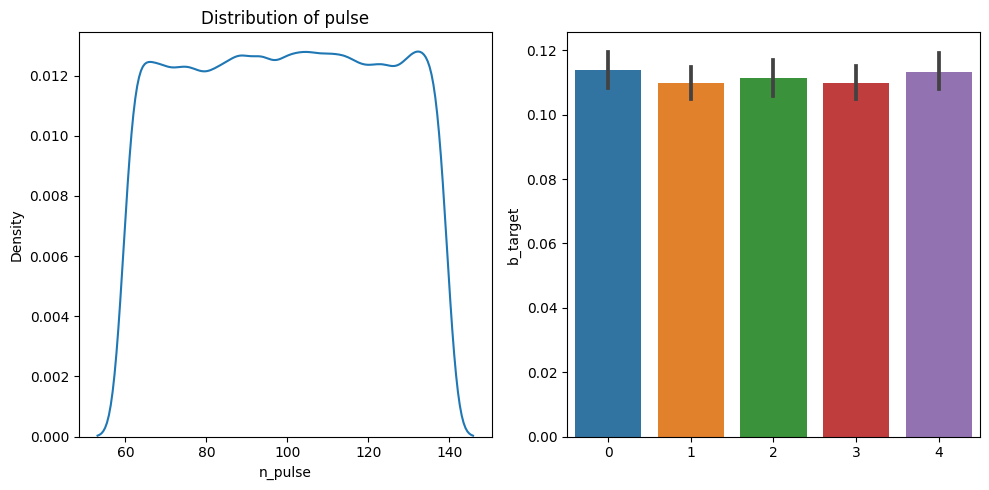

In [534]:
# Plot the pulse distribution
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
# KDE plot
sns.kdeplot(data['n_pulse'], ax=ax[0])
# Target mean by pulse
group = data.groupby('n_pulse')['b_target'].mean()
# Cut the pulse into 10 bins
group = pd.cut(group.index, bins=5, labels=range(5))
# Plot the mean target by pulse
sns.barplot(x=group, y=data.groupby('n_pulse')['b_target'].mean(), ax=ax[1])
ax[0].set_title('Distribution of pulse')
plt.tight_layout()
plt.show()

In [535]:
data = data.drop('n_pulse', axis=1)

#### __10. Discharge Disposition__
__Modifications:__
- Grouping the different discharge dispositions into new categories (by the target mean), and one hot encoding
<br>

__Relevant Information:__
- A lot of relevant information for the model, with a higher percentage of people readmitted in some categories, especially with discharged SNF (skilled nursing facility) and rehab, because of the high count and target mean.
__________________________________________

,count,target_mean,percentage,distance (%)
Discharged to home,42254,0.093,59.32,-16.70
Discharged/transferred to SNF,9780,0.146,13.73,30.77
Discharged/transferred to home with home health service,9005,0.126,12.64,12.85
NaN,3269,0.121,4.59,8.38
Discharged/transferred to another short term hospital,1488,0.165,2.09,47.79
Discharged/transferred to another rehab fac including rehab units of a hospital .,1392,0.279,1.95,149.89
Expired,1135,0.000,1.59,-100.00
Discharged/transferred to another type of inpatient care institution,822,0.209,1.15,87.20
Discharged/transferred to ICF,571,0.124,0.80,11.06
Left AMA,421,0.147,0.59,31.66


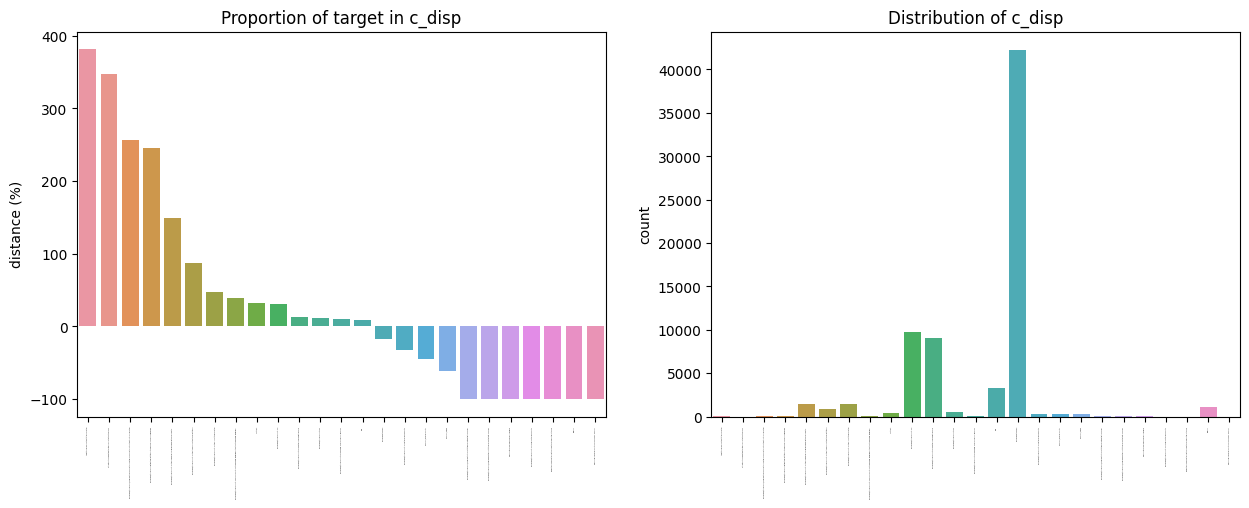

In [536]:
var_report('c_disp', data)

In [537]:
# Lets group the discharge dispositions into groups
group = data.groupby('c_disp', dropna=False)['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group_ = group[group['count'] > 200]
group_


,mean,std,count
c_disp,,,
Discharged/transferred to another rehab fac including rehab units of a hospital .,0.278736,0.448538,1392
Discharged/transferred to another type of inpatient care institution,0.209246,0.407018,822
Discharged/transferred to another short term hospital,0.165323,0.371596,1488
Left AMA,0.147268,0.354795,421
Discharged/transferred to SNF,0.146217,0.353341,9780
Discharged/transferred to home with home health service,0.126374,0.332289,9005
Discharged/transferred to ICF,0.124343,0.330262,571
NaN,0.121444,0.326692,3269
Discharged to home,0.092749,0.290083,42254


In [538]:
def map_to_label(value):
   if value > 0.25:
       return 'rehab'
   elif value <= 0.25 and value > 0.2:
       return 'transCare'
   elif value <= 0.2 and value > 0.15:
       return 'transHosp'
   elif value <= 0.15 and value > 0.14:
       return 'disSNF'
   elif value <= 0.14 and value > 0.124:
       return 'disHHS'
   elif value <= 0.124 and value > 0.12:
       return 'disNone'
   elif value <= 0.12 and value > 0.09:
       return 'disHome'
   elif value <= 0.09 and value > 0.02:
       return 'disHospice'
   else:
       return 'disExpired'
   
data['c_disp'] = data['c_disp'].map(group['mean'].apply(map_to_label))
data.groupby('c_disp')['b_target'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
c_disp,,
rehab,1549,0.291801
transCare,822,0.209246
transHosp,1520,0.165132
disSNF,10201,0.146260
disHHS,9576,0.126253
disNone,3350,0.121493
disHome,42254,0.092749
disHospice,799,0.060075
disExpired,1162,0.000000


In [539]:
c_disp = data['c_disp']
data = one_hot_encode(data, 'c_disp', drop_first=False)

#### __11. Admission Source__
__Modifications:__
- Grouping into 5 groups and one hot encoding 4 of them (removing the other group because of the low count)
<br>

__Relevant Information:__
- Some relevant information for the model, especially with emergency room. 
- We crossed the admission source and the admission type, because it could provide valuable information for the model. Not much relevant was found
__________________________________________

,count,target_mean,percentage,distance (%)
Emergency Room,40317,0.117,56.60,4.66
Physician Referral,20677,0.105,29.03,-6.07
NaN,4825,0.108,6.77,-3.39
Transfer from a hospital,2230,0.096,3.13,-14.12
Transfer from another health care facility,1562,0.097,2.19,-13.23
Clinic Referral,779,0.105,1.09,-6.07
Transfer from a Skilled Nursing Facility (SNF),595,0.128,0.84,14.50
HMO Referral,129,0.155,0.18,38.66
Not Available,88,0.080,0.12,-28.43
Court/Law Enforcement,11,0.182,0.02,62.81


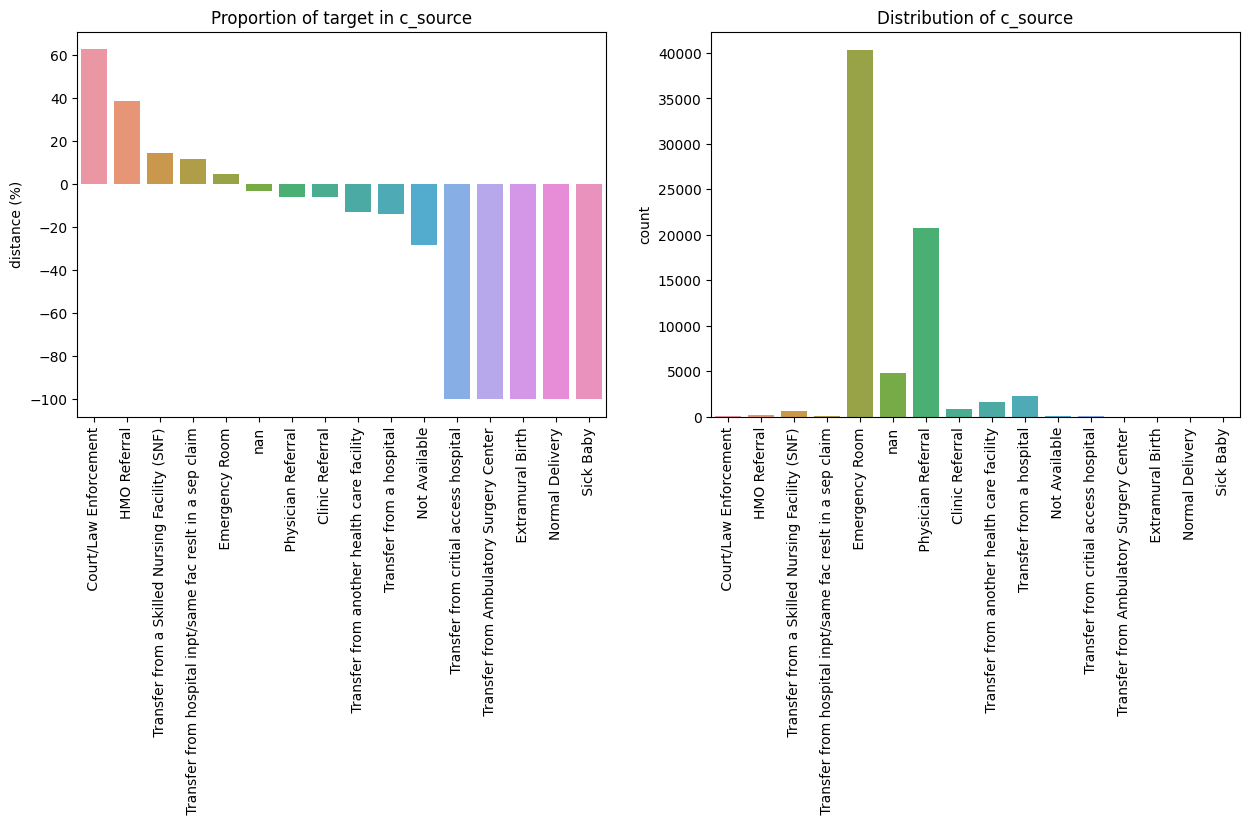

In [540]:
var_report('c_source', data)

Lets make some small changes to the data to make it easier to work with. We are going to group low count categories and change names 

In [541]:
group = data.groupby('c_source', dropna=False)['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group

,mean,std,count
c_source,,,
Court/Law Enforcement,0.181818,0.404520,11
HMO Referral,0.155039,0.363353,129
Transfer from a Skilled Nursing Facility (SNF),0.127731,0.334071,595
Transfer from hospital inpt/same fac reslt in a sep claim,0.125000,0.353553,8
Emergency Room,0.116626,0.320978,40317
NaN,0.107565,0.309862,4825
Clinic Referral,0.105263,0.307089,779
Physician Referral,0.105189,0.306805,20677
Transfer from another health care facility,0.097311,0.296476,1562


In [542]:
# Low count categories will be grouped into other
low_count  = group[group['count'] < 100].index
data['c_source'] = data['c_source'].replace(low_count, 'Other')

# C_sources with the word 'Referral' will be grouped into 'Referral'
referral = [col for col in data['c_source'].dropna().unique() if 'Referral' in col]
data['c_source'] = data['c_source'].replace(referral, 'Referral')

# Transfer from a hospital will be grouped into 'Transfer' - Although there is a higher mean target in some of the transfer categories, we also have to look at the std
transfer = [col for col in data['c_source'].dropna().unique() if 'Transfer' in col]
data['c_source'] = data['c_source'].replace(transfer, 'Transfer')

# Name Nan values as 'Unknown'
data['c_source'] = data['c_source'].fillna('Unknown')

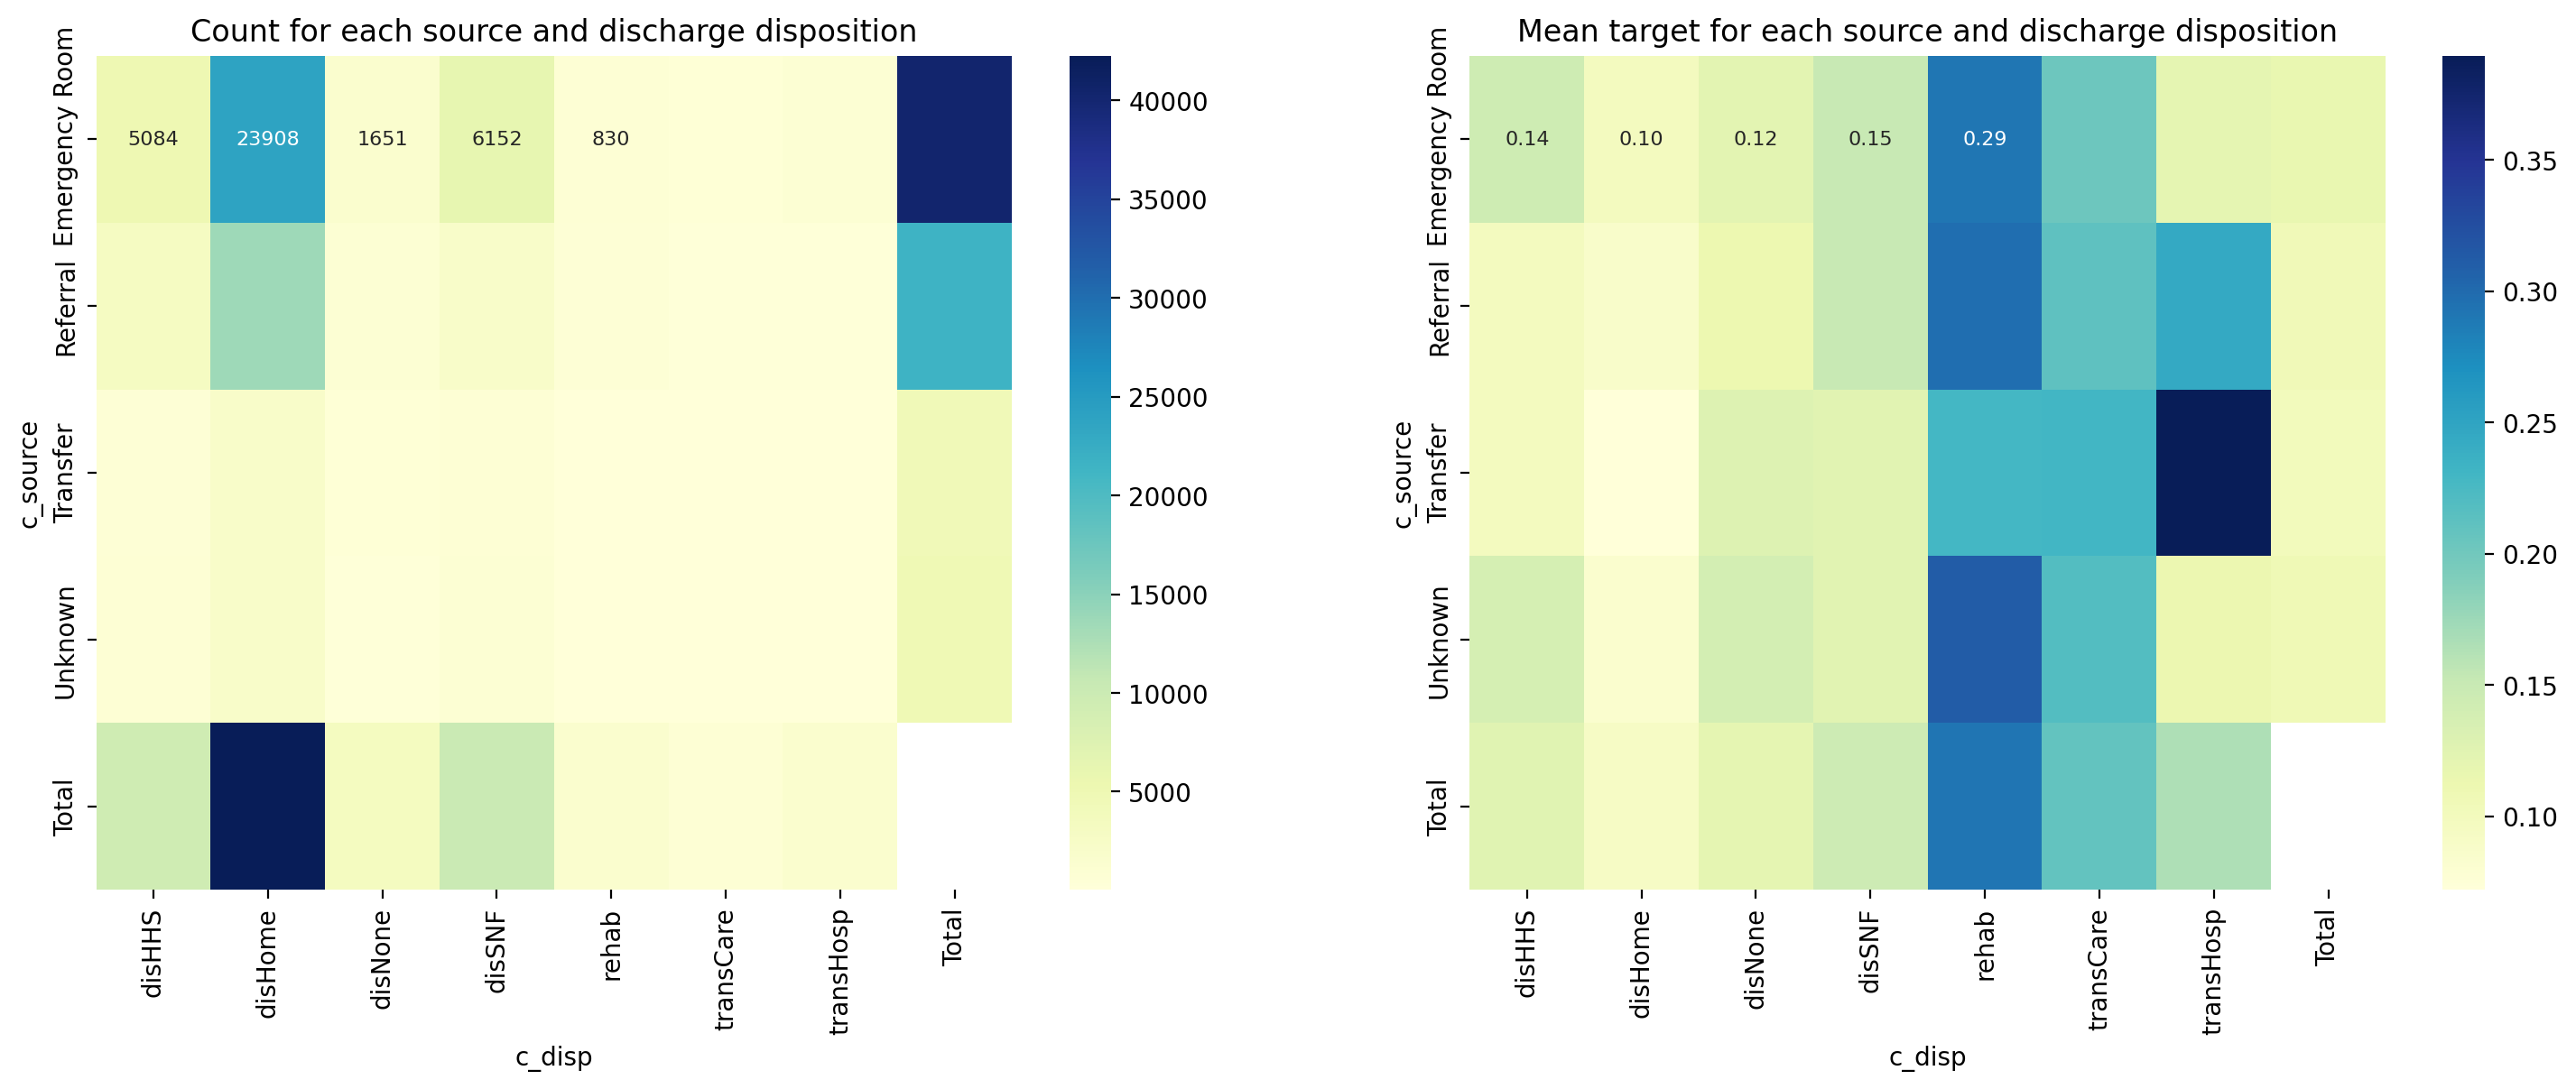

In [543]:
data['c_disp'] = c_disp

fig, ax = plt.subplots(figsize=(18, 6), ncols=2, nrows=1, dpi=200)
group = data.groupby(['c_source', 'c_disp'])['b_target'].mean().unstack()
group_count = data.groupby(['c_source', 'c_disp'])['b_target'].count().unstack()

counts_total = data.groupby('c_disp')['b_target'].count()
counts_total_ = data.groupby('c_source')['b_target'].count()    
group_count.loc['Total'] = counts_total
group_count['Total'] = counts_total_

means_total = data.groupby('c_disp')['b_target'].mean()
means_total_ = data.groupby('c_source')['b_target'].mean()
group.loc['Total'] = means_total
group['Total'] = means_total_

group = group.drop('Other').drop(['disExpired', 'disHospice'], axis=1)
group_count = group_count.drop('Other').drop(['disExpired', 'disHospice'], axis=1)

# Make the heatmaps
sns.heatmap(group_count, ax=ax[0], annot=True, fmt='.0f', cmap='YlGnBu', cbar=True, annot_kws={"size": 8})
sns.heatmap(group, ax=ax[1], annot=True, fmt='.2f', cmap='YlGnBu', cbar=True, annot_kws={"size": 8})

ax[0].set_title('Count for each source and discharge disposition')
ax[1].set_title('Mean target for each source and discharge disposition')
plt.show()

data.drop('c_disp', axis=1, inplace=True)

Not much to conclude. Lets just one hot encode the variable

In [544]:
data = one_hot_encode(data, 'c_source', drop_first=False)
data.drop('b_source_Other', axis=1, inplace=True)

#### __12. Length of stay__
__Modifications:__
- None 
<br>

__Relevant Information:__
- Cubic or quadratic relationship with the target mean. Very imoprtant variable for the model
__________________________________________

,count,target_mean,percentage,distance (%)
3,12434,0.108,17.46,-3.23
2,12119,0.099,17.01,-11.29
1,10008,0.084,14.05,-24.73
4,9656,0.118,13.56,5.74
5,6967,0.120,9.78,7.53
6,5237,0.121,7.35,8.42
7,4154,0.132,5.83,18.28
8,3002,0.146,4.21,30.83
9,2105,0.133,2.96,19.18
10,1637,0.139,2.30,24.55


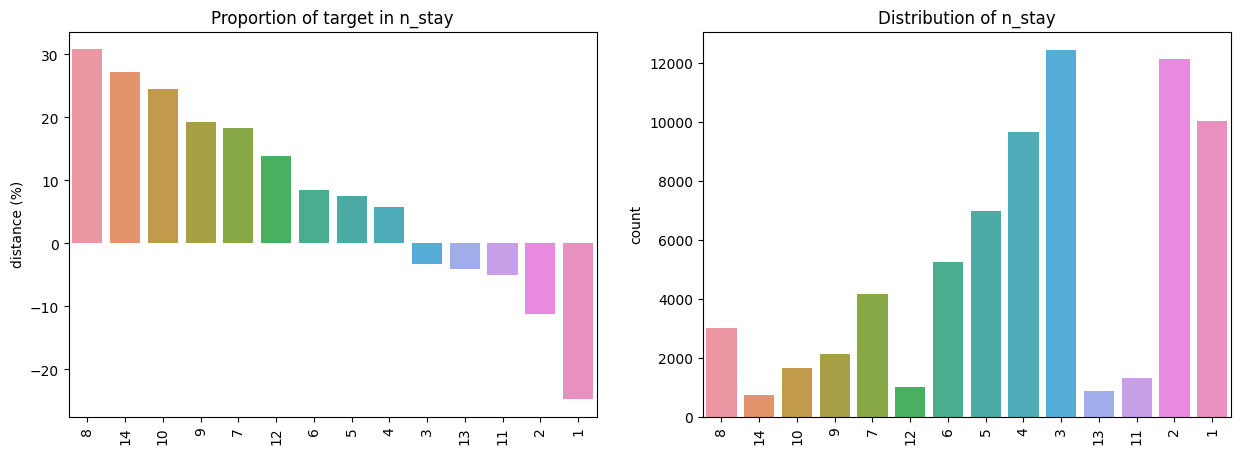

In [545]:
var_report('n_stay', data)

We also need information about the standard deviation by n_stay so as to avoid overfitting (8 day stay shouldnt make a patient readmission more likely than a 9 day stay)

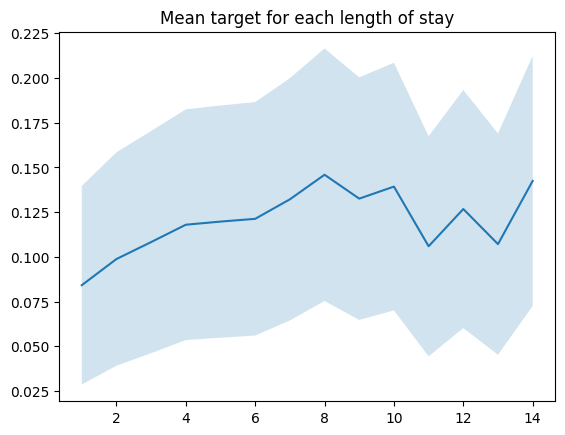

In [546]:
group = data.groupby('n_stay')['b_target'].agg(['mean', 'std', 'count'])
# Plot the group means and stds
plt.plot(group['mean'])
# Plot bands for the std
plt.fill_between(group.index, group['mean'] - 0.2*group['std'], group['mean'] + 0.2*group['std'], alpha=0.2)
plt.title('Mean target for each length of stay')
plt.show()

There seem to be non-linear relationships between the length of stay and the readmission rate. Random forest and NNs should be able to capture this non-linearity

#### __13. Number of tests__
__Modifications:__
- Grouping the number of tests into 5 groups that filter the noise
<br>

__Relevant Information:__
- Good correlation between the number of tests and the readmission rate, although quite noisy
__________________________________________

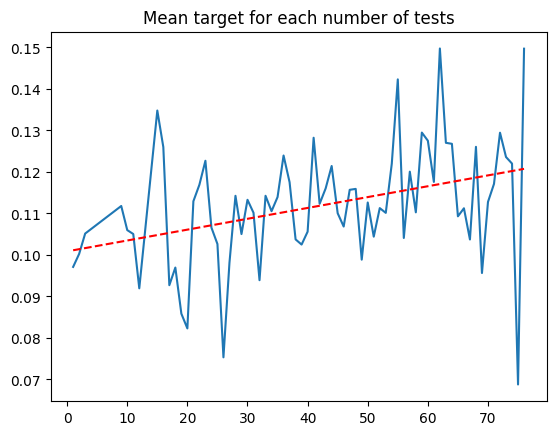

In [547]:
# Too large to generate a var report
group = data.groupby('n_tests')['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group_ = group[group['count'] > 300].copy()
group_.sort_index(inplace=True)
plt.plot(group_['mean'])
# Fit a regression line
z = np.polyfit(group_.index, group_['mean'], 1)
p = np.poly1d(z)
plt.plot(group_.index, p(group_.index), 'r--')
plt.title('Mean target for each number of tests')
plt.show()

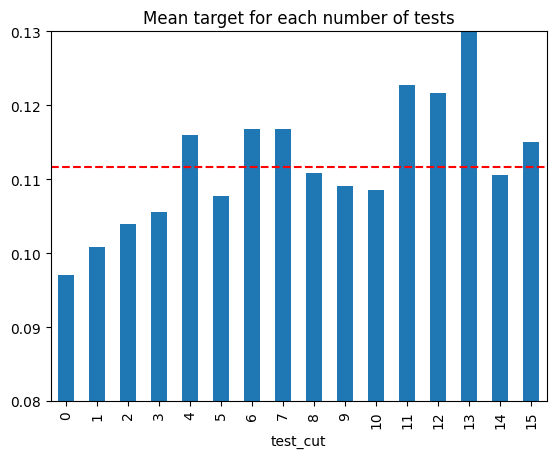

In [548]:
k = 16
# Group them into k groups with more or less the same count
group.sort_index(inplace=True)
group['cumulative_count'] = group['count'].cumsum()

# Cut the cumulative count into k groups
group['group'] = pd.cut(group['cumulative_count'], bins=k, labels=range(k))
mapper = group['group'].to_dict()

data['test_cut'] = data['n_tests'].map(mapper)
data.groupby('test_cut')['b_target'].mean().plot.bar()
plt.ylim(0.08, 0.13)
plt.axhline(data['b_target'].mean(), color='red', linestyle='--')
plt.title('Mean target for each number of tests')
plt.show()

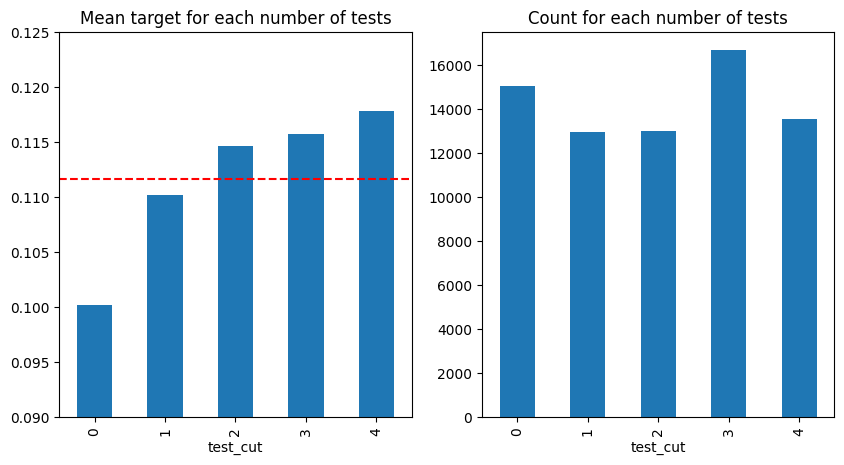

In [549]:
# Group 3,4 together, 5,6 together and 7,8 together and 10,11 together
data['test_cut'] = data['test_cut'].replace({0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3, 12:3, 14:4, 13:4, 15:4})

ax, fig = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
data.groupby('test_cut')['b_target'].mean().plot.bar(ax=fig[0])
data.groupby('test_cut')['b_target'].count().plot.bar(ax=fig[1])
# Plot an axhline for the mean target
fig[0].axhline(data['b_target'].mean(), color='red', linestyle='--') 
fig[0].set_title('Mean target for each number of tests')
fig[1].set_title('Count for each number of tests')
# Change the ylim of the mean target plot
fig[0].set_ylim(0.09, 0.125)
plt.show()

In [550]:
data['n_tests'] = data['test_cut']
data.drop('test_cut', axis=1, inplace=True)

#### __14. Number of non lab procedures__
__Modifications:__
- Creating the 1 non lab test column (binary)
<br>

__Relevant Information:__
- Negative correlation between the number of non lab procedures and the readmission rate, if we exclude the 1 value, which is the most important one. We will keep the 1 value and create a binary column
__________________________________________

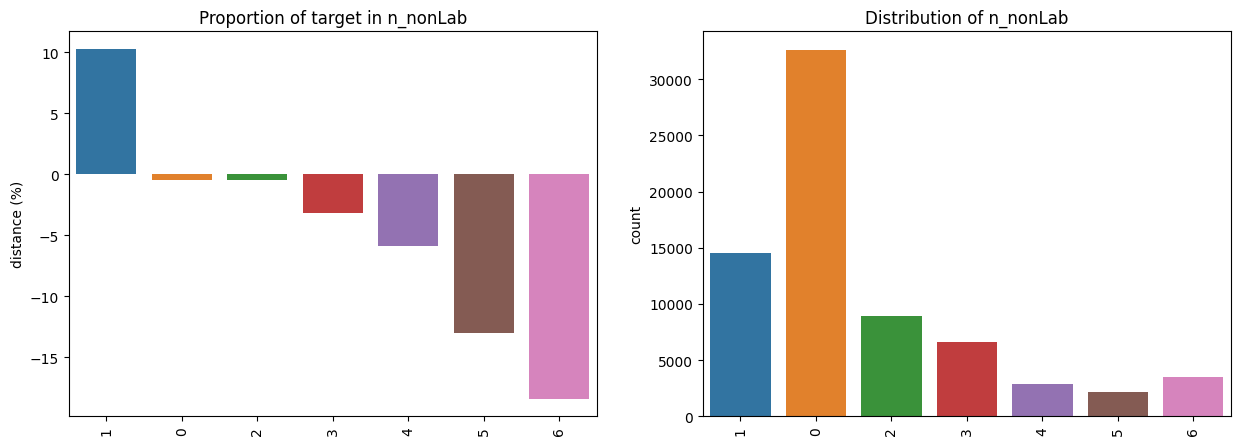

In [551]:
var_report('n_nonLab', data)

Lets leave it as it is, because it has a good correlation with the target mean, but we will create a variable for the 1 value, as it carries the most information

In [552]:
data['b_1nonLab'] = (data['n_nonLab'] == 1).astype(np.int8)

#### __15. Number of Medications__
__Modifications:__
- Same as in the number of tests
<br>

__Relevant Information:__
- Positive correlation between the number of medications and the readmission rate, although quite noisy
__________________________________________

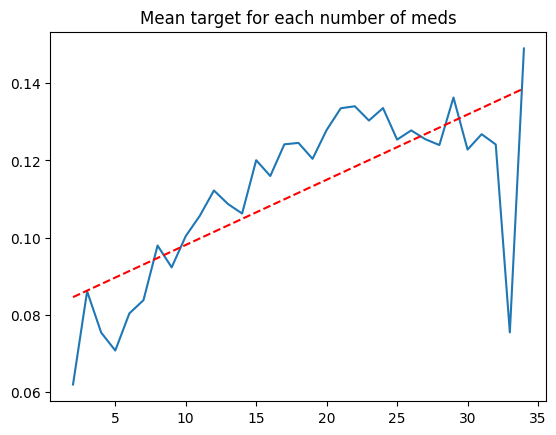

In [553]:
# Too large to generate a var report
group = data.groupby('n_meds')['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group_ = group[group['count'] > 300].copy()
group_.sort_index(inplace=True)
plt.plot(group_['mean'])
# Fit a regression line
z = np.polyfit(group_.index, group_['mean'], 1)
p = np.poly1d(z)
plt.plot(group_.index, p(group_.index), 'r--')
plt.title('Mean target for each number of meds')
plt.show()

Lets do exactly the same as we did with the number of tests

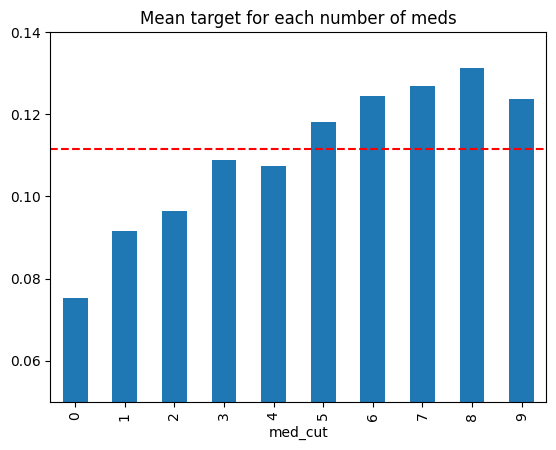

In [554]:
k = 10
# Group them into k groups with more or less the same count
group.sort_index(inplace=True)
group['cumulative_count'] = group['count'].cumsum()

# Cut the cumulative count into k groups
group['group'] = pd.cut(group['cumulative_count'], bins=k, labels=range(k))
mapper = group['group'].to_dict()

data['med_cut'] = data['n_meds'].map(mapper)
data.groupby('med_cut')['b_target'].mean().plot.bar()
plt.ylim(0.05, 0.14)
plt.axhline(data['b_target'].mean(), color='red', linestyle='--')
plt.title('Mean target for each number of meds')
plt.show()

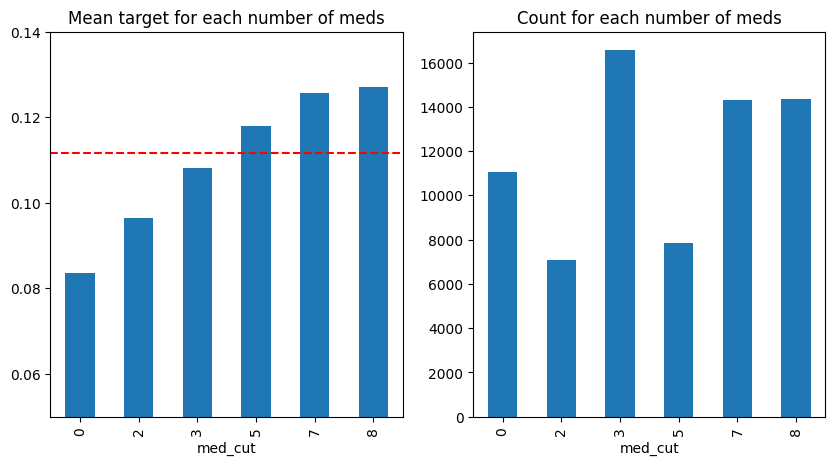

In [555]:
# Group 3,4 together, 5,6 together and 7,8 together and 10,11 together
data['med_cut'] = data['med_cut'].replace({4:3, 6:7, 9:8, 1:0})

ax, fig = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
data.groupby('med_cut')['b_target'].mean().plot.bar(ax=fig[0])
data.groupby('med_cut')['b_target'].count().plot.bar(ax=fig[1])
# Plot an axhline for the mean target
fig[0].axhline(data['b_target'].mean(), color='red', linestyle='--')
fig[0].set_title('Mean target for each number of meds')
fig[1].set_title('Count for each number of meds')
# Change the ylim of the mean target plot
fig[0].set_ylim(0.05, 0.14)
plt.show()

In [556]:
data['med_cut'] = data['med_cut'].replace({2:1, 3:2, 5:3, 7:4, 8:5})
data['n_meds'] = data['med_cut']
data.drop('med_cut', axis=1, inplace=True)

#### __16. Diagnosis (1,2,3)__
__Modifications:__
- Merging the 3 diagnosis columns into 1, separating the codes from diabetes and codes not from diabetes
- Creating 2 new columns called num_diabetes and num_severity, which show how severe the diagnosis is
- Deleting the 3 diagnosis columns
<br>

__Relevant Information:__
- Very relevant information from the diagnosis. 250 codes refer to diabetes, which seems to be quite important
__________________________________________

In [557]:
group1 = data.groupby('c_diag1')['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group2 = data.groupby('c_diag2')['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group3 = data.groupby('c_diag3')['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)

# Filter groups based on count > 200
filtered_group1 = group1[group1['count'] > 500]
filtered_group2 = group2[group2['count'] > 500]
filtered_group3 = group3[group3['count'] > 500]

# Display side by side
display(HTML("""
    <div style="display: flex; justify-content: space-between;">
        <div>
            <h3>Group 1:</h3>
            {}
        </div>
        <div>
            <h3>Group 2:</h3>
            {}
        </div>
        <div>
            <h3>Group 3:</h3>
            {}
        </div>
    </div>
""".format(
    filtered_group1.to_html(),
    filtered_group2.to_html(),
    filtered_group3.to_html()
)))

,mean,std,count
c_diag1,,,
250.7,0.197987,0.398817,596
250.6,0.183990,0.387708,837
820,0.167320,0.373506,765
434,0.162625,0.369155,1402
440,0.156357,0.363506,582
996,0.139690,0.346793,1353
428,0.138819,0.345794,4776
584,0.137606,0.344648,1061
V57,0.136732,0.343764,863


##### For the diabetes intensity variable variable 

In [558]:
# Change the data type of the diagnosis columns to string
data['c_diag1'] = data['c_diag1'].astype(str)
data['c_diag2'] = data['c_diag2'].astype(str)
data['c_diag3'] = data['c_diag3'].astype(str)

diabetes1 = data.apply(lambda x: x['c_diag1'] if x['c_diag1'].startswith('250') else np.nan, axis=1)
diabetes2 = data.apply(lambda x: x['c_diag2'] if x['c_diag2'].startswith('250') else np.nan, axis=1)
diabetes3 = data.apply(lambda x: x['c_diag3'] if x['c_diag3'].startswith('250') else np.nan, axis=1)

diabetes = pd.concat([diabetes1, diabetes2, diabetes3], axis=1)

# Melt the dataframe
melted_diabetes = diabetes.reset_index().melt(id_vars='encounter_id', value_name='diabetes').drop('variable', axis=1).set_index('encounter_id')
del_dup = diabetes[diabetes.isna().min(axis=1) == False].index.tolist()

# Drop the excess rows from the diabetic people 
melted_1 = melted_diabetes.loc[del_dup].dropna()

# Keep only one row for each encounter id
melted_2_index = melted_diabetes.loc[~melted_diabetes.index.isin(del_dup)].index.unique()
melted_2 = pd.DataFrame(index=melted_2_index, columns=['diabetes'])

# Concatenate the two dataframes
melted_diabetes = pd.concat([melted_1, melted_2], axis=0).sort_index()

# Add the target to the melted diabetes dataframe
full_melted = melted_diabetes.join(data['b_target'])
# full_melted = full_melted[full_melted['b_target'].notna()]
full_melted

# Lets now group the diagnoses into groups
group = full_melted.groupby('diabetes')['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group_ = group[group['count'] > 500]
group_

,mean,std,count
diabetes,,,
250.7,0.196154,0.397341,780
250.6,0.176632,0.381444,2191
250.82,0.158103,0.365198,506
250.11,0.131737,0.338542,501
250.13,0.127031,0.333254,677
250.01,0.123924,0.329590,1743
250.8,0.121290,0.326570,1550
250.4,0.119086,0.324155,613
250.02,0.108803,0.311446,2840


In [559]:
# Now group the diagnoses into groups
group_1 = group[group['mean'] > 0.18].index
group_2 = group[(group['mean'] <= 0.18) & (group['mean'] > 0.175)].index
group_3 = group[(group['mean'] <= 0.175) & (group['mean'] > 0.15)].index
group_4 = group[(group['mean'] <= 0.15) & (group['mean'] > 0.13)].index
group_5 = group[(group['mean'] <= 0.13) & (group['mean'] > 0.115)].index
group_6 = group[(group['mean'] <= 0.115)].index

def map_to_label_diabetes(value):
    if value in group_1:
        return 6
    elif value in group_2:
        return 5
    elif value in group_3:
        return 4
    elif value in group_4:
        return 3
    elif value in group_5:
        return 2
    elif value in group_6:
        return 0

mapped_diabetes = full_melted['diabetes'].apply(map_to_label_diabetes)

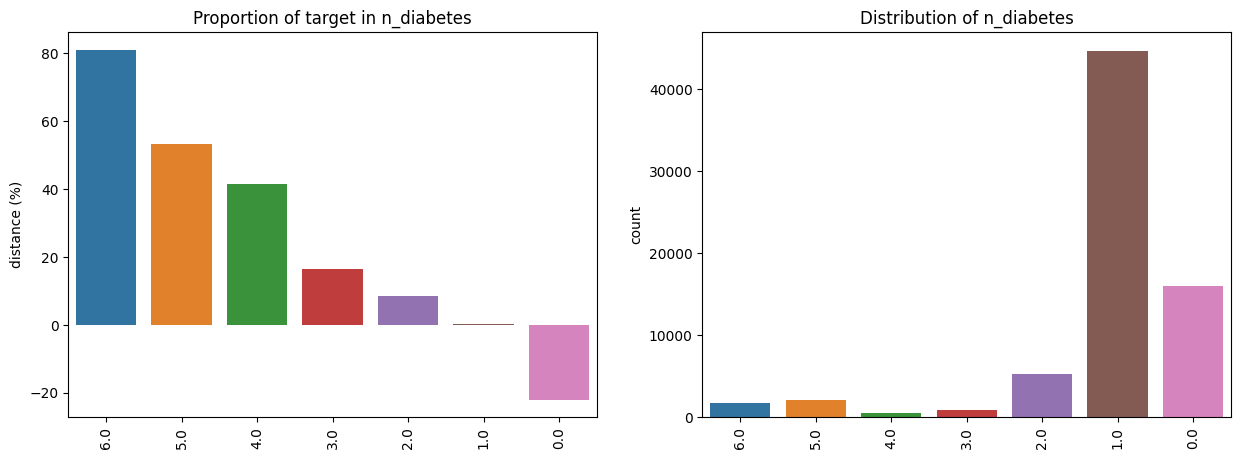

In [560]:
# For the dupplicates, we will keep the highest label
mapped_diabetes = mapped_diabetes.groupby(mapped_diabetes.index).max()
mapped_diabetes.fillna(1, inplace=True)
data['n_diabetes'] = mapped_diabetes
var_report('n_diabetes', data)

##### For the non diabetes intensity variable

In [561]:
# Lets do the same for the other diagnoses
other1 = data.apply(lambda x: x['c_diag1'] if x['c_diag1'].startswith('250') == False else np.nan, axis=1)
other2 = data.apply(lambda x: x['c_diag2'] if x['c_diag2'].startswith('250') == False else np.nan, axis=1)
other3 = data.apply(lambda x: x['c_diag3'] if x['c_diag3'].startswith('250') == False else np.nan, axis=1)

other = pd.concat([other1, other2, other3], axis=1)

# Melt the dataframe
melted_other = other.reset_index().melt(id_vars='encounter_id', value_name='other').drop('variable', axis=1).set_index('encounter_id')
melted_other = melted_other.dropna()

# Add the target to the melted diabetes dataframe
full_melted = melted_other.join(data['b_target'])

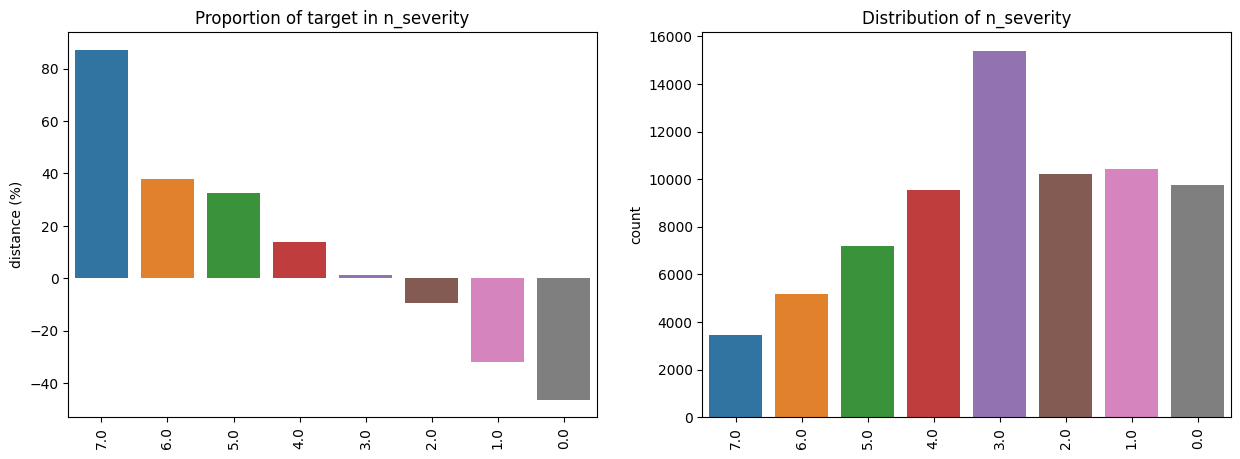

In [562]:
group = full_melted.groupby('other')['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group_ = group[group['count'] > 2000]

# Now group the diagnoses into groups
group_1 = group[group['mean'] > 0.175].index
group_2 = group[(group['mean'] <= 0.175) & (group['mean'] > 0.16)].index
group_3 = group[(group['mean'] <= 0.16) & (group['mean'] > 0.15)].index
group_4 = group[(group['mean'] <= 0.15) & (group['mean'] > 0.135)].index
group_5 = group[(group['mean'] <= 0.135) & (group['mean'] > 0.1245)].index
group_6 = group[(group['mean'] <= 0.1245) & (group['mean'] > 0.115)].index
group_7 = group[(group['mean'] <= 0.115) & (group['mean'] > 0.1)].index
group_8 = group[(group['mean'] <= 0.1)].index

def map_to_label_other(value):
    if value in group_1:
        return 7
    elif value in group_2:
        return 6
    elif value in group_3:
        return 5
    elif value in group_4:
        return 4
    elif value in group_5:
        return 3
    elif value in group_6:
        return 2
    elif value in group_7:
        return 1
    elif value in group_8:
        return 0
    
mapped_other = full_melted['other'].apply(map_to_label_other)

# For the dupplicates, we will keep the highest label
mapped_other = mapped_other.groupby(mapped_other.index).max()

data['n_severity'] = mapped_other
data['n_severity'].ffill(inplace=True)

var_report('n_severity', data)

##### Droping the 3 diagnosis columns

In [563]:
data = data.drop(['c_diag1', 'c_diag2', 'c_diag3'], axis=1)

#### __17. Number of Diagnosis__
__Modifications:__
- Clipping to 9 
<br>

__Relevant Information:__
- Good correlation between the number of diagnosis and the readmission rate until 9, which is why we clipped it there. 9 has a higher readmission rate than average, so it contains information, especially because it has a high count
__________________________________________

,count,target_mean,percentage,distance (%)
9,34668,0.124,48.67,11.40
5,7920,0.089,11.12,-20.04
8,7375,0.117,10.35,5.12
7,7264,0.109,10.20,-2.07
6,7134,0.103,10.02,-7.46
4,3902,0.081,5.48,-27.23
3,1994,0.077,2.80,-30.82
2,727,0.059,1.02,-46.99
1,164,0.049,0.23,-55.98
16,33,0.121,0.05,8.71


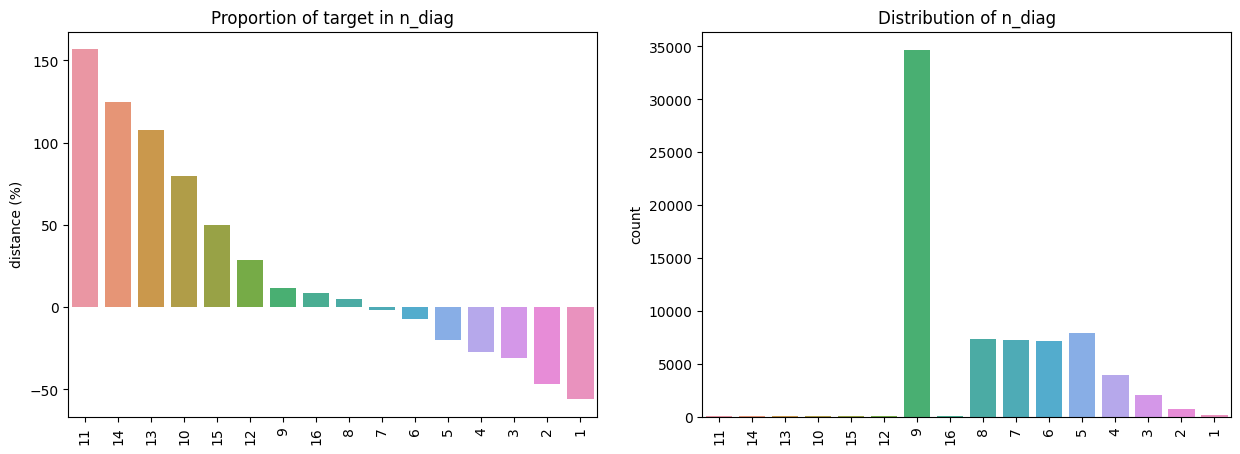

In [564]:
var_report('n_diag', data)

In [565]:
# Clip to 9 
data['n_diag'] = data['n_diag'].clip(upper=9)

#### __18. Glucose Tests__
__Modifications:__
- Droping the a1c test column and modifying the glucose test column
<br>

__Relevant Information:__
- No relevant information, especially for the a1c test - even the absence of a test doesn't seem to be relevant 
- A little bit of relevant information for the glucose test, but not much
__________________________________________

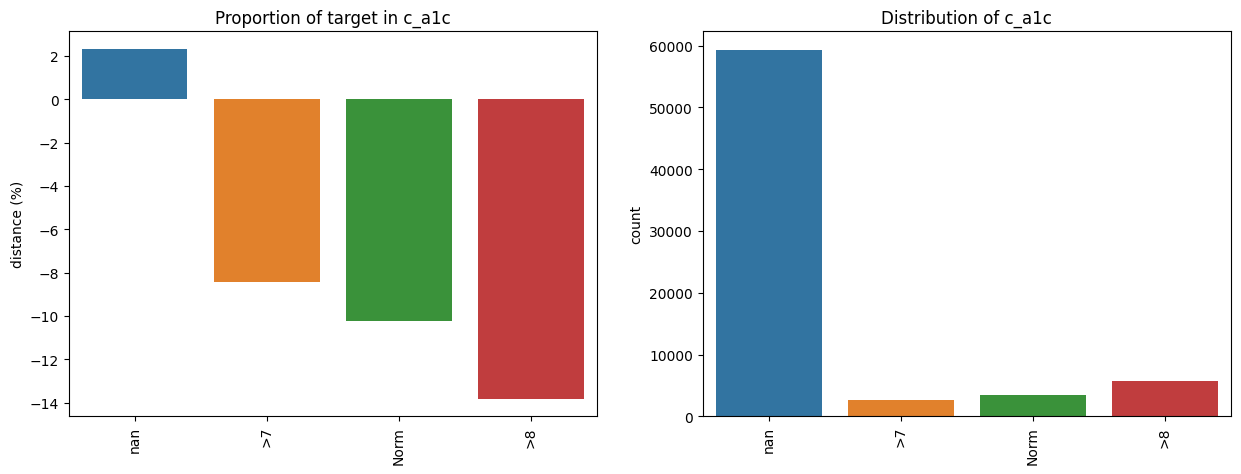

In [566]:
var_report('c_a1c', data)
data = data.drop('c_a1c', axis=1)

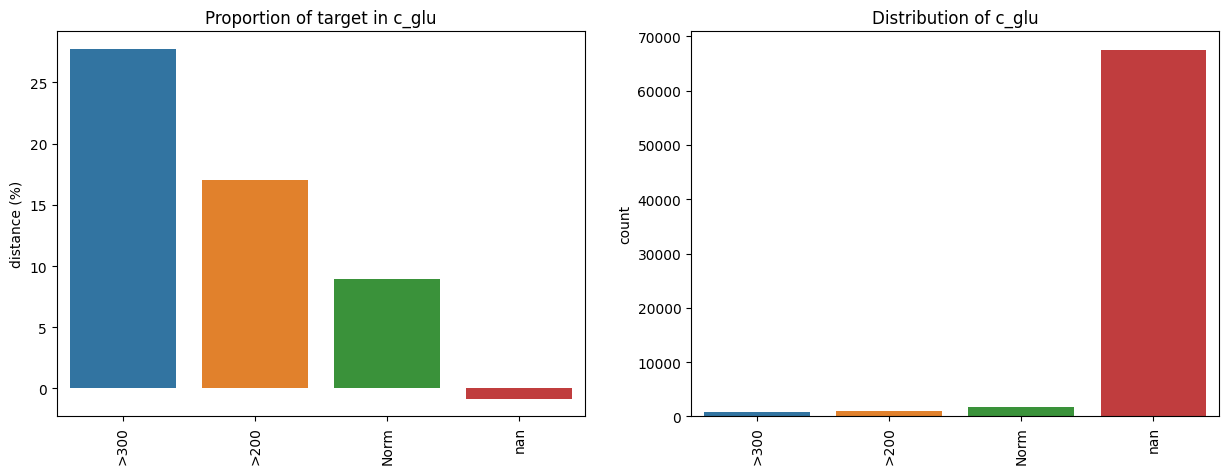

In [567]:
var_report('c_glu', data)

In [568]:
# One hot encode the glucose test result
data = one_hot_encode(data, 'c_glu', drop_first=False)

#### __19. Change in Meds__
__Modifications:__
- NONE
<br>

__Relevant Information:__
- Some relevant information for the model. The change in meds seems to be relevant
- No nan values
__________________________________________

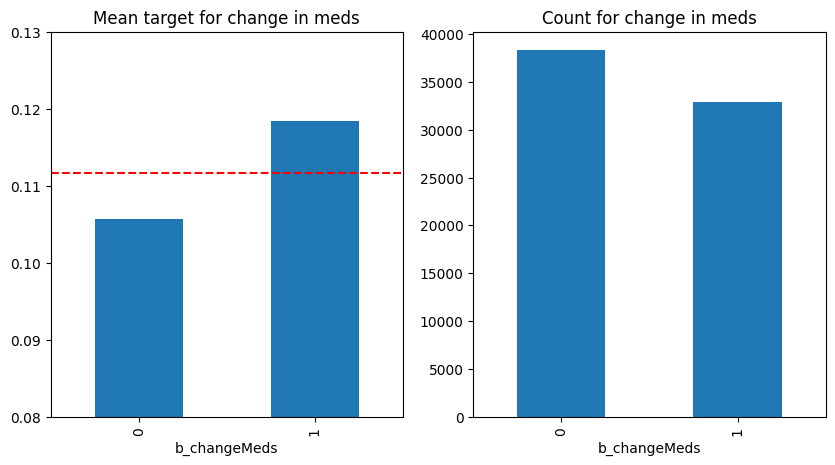

In [569]:
# Plot the mean target for the binary change in meds variable and on the side the count
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
data.groupby('b_changeMeds')['b_target'].mean().plot.bar(ax=ax[0])
data.groupby('b_changeMeds')['b_target'].count().plot.bar(ax=ax[1])
# Plot an axhline for the mean target
ax[0].axhline(data['b_target'].mean(), color='red', linestyle='--')
ax[0].set_title('Mean target for change in meds')
ax[1].set_title('Count for change in meds')
ax[0].set_ylim(0.08, 0.13)
plt.show()

#### __20. Diabetes Meds__
__Modifications:__
- NONE
<br>

__Relevant Information:__
- Same thing as the change in meds
__________________________________________

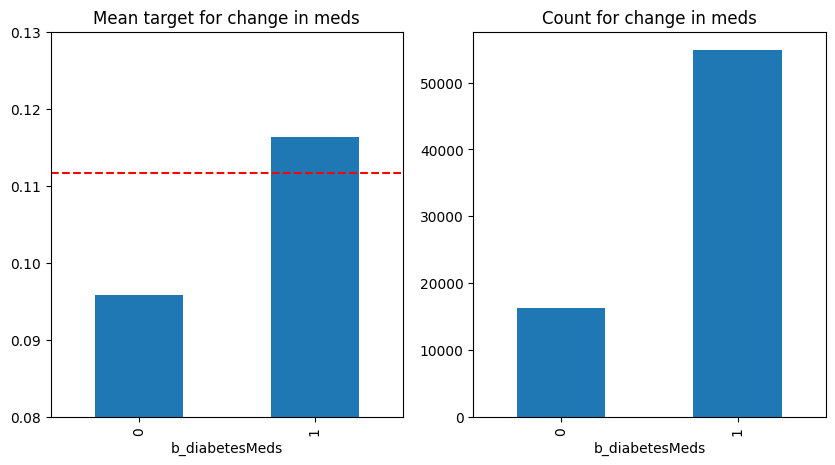

In [570]:
# Plot the mean target for the binary change in meds variable and on the side the count
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
data.groupby('b_diabetesMeds')['b_target'].mean().plot.bar(ax=ax[0])
data.groupby('b_diabetesMeds')['b_target'].count().plot.bar(ax=ax[1])
# Plot an axhline for the mean target
ax[0].axhline(data['b_target'].mean(), color='red', linestyle='--')
ax[0].set_title('Mean target for change in meds')
ax[1].set_title('Count for change in meds')
ax[0].set_ylim(0.08, 0.13)
plt.show()

#### __21. Medications__
__Modifications:__
- Extracting the array of medications and creating many binary columns
- Keeping only repaglinide and insulin
<br>

__Relevant Information:__
- Only repaglinide and insulin seem to be relevant for the model
__________________________________________

In [571]:
# Transforming the medication list into many dummy variables
meds = data['c_medication'].str.get_dummies(sep=',')

# Remove any symbols from the column names
to_remove = ['[', ']', "'", ' ']
for symbol in to_remove:
    meds.columns = meds.columns.str.replace(re.escape(symbol), '', regex=True)

unique_cols = meds.columns.unique()
new_meds = pd.DataFrame(columns=unique_cols)
for col in unique_cols:
    if type(meds[col]) == pd.Series:
        new_meds[col] = meds[col]
    else:
        new_meds[col] = meds[col].max(axis=1)
meds = new_meds

# Lets delete combinations of drugs
for col in meds.columns.unique():
    if '-' in col:
        meds.drop(col, axis=1, inplace=True)

# Rename the last column to avoid confusion
meds.rename(columns={'' : 'noMeds'}, inplace=True)

# Add a b_ prefix to the column names
meds.columns = ['b_' + col for col in meds.columns]

data = pd.concat([data,meds], axis=1)
# Deleting the medication column
data.drop('c_medication', axis=1, inplace=True)

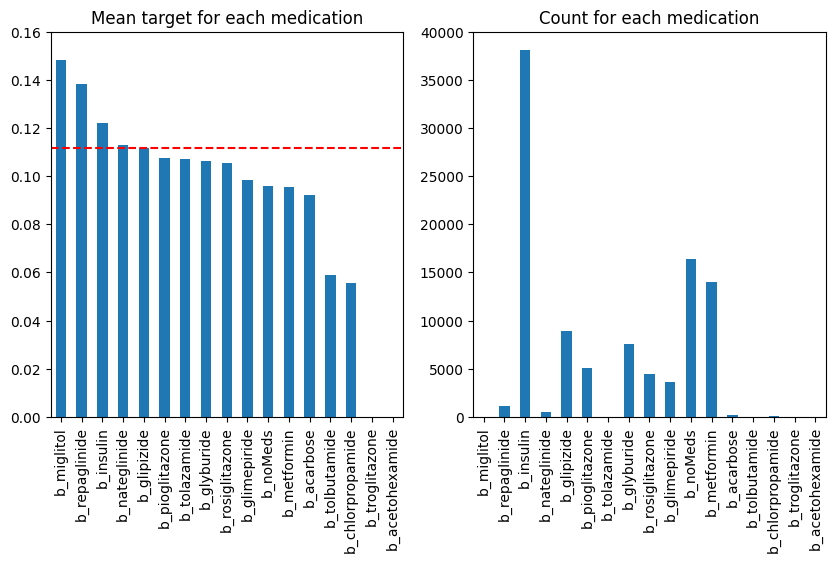

In [572]:
meds_exploration = data[meds.columns.tolist()+['b_target']]

group = meds_exploration.groupby('b_target').sum().T
group['total'] = group.sum(axis=1)
group['mean'] = group[1] / group['total']
group.sort_values(by='mean', ascending=False, inplace=True) 

# Plot the mean target for each medication and on the side the count
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
group['mean'].plot.bar(ax=ax[0])
group['total'].plot.bar(ax=ax[1])
# Plot an axhline for the mean target
ax[0].axhline(data['b_target'].mean(), color='red', linestyle='--')
ax[0].set_title('Mean target for each medication')
ax[1].set_title('Count for each medication')
ax[0].set_ylim(0, 0.16)
plt.show()



In [573]:
data = data.drop(list(set(meds.columns)-set(['b_insulin', 'b_repaglinide'])), axis=1)

### __Imputing missing values__

In [574]:
train_ids = list(set(train_ids) - set(ids_to_drop))
train = data.loc[train_ids]
test = data.loc[test_ids]

##### Age

In [575]:
print('Before', data['n_age'].isna().sum())
# Step 1: Split the DataFrame
data_age = train[train['n_age'].notna()]
missing_age = data[data['n_age'].isna()].copy()

# Step 2: Create a mapper
mapper = data_age.groupby('c_patient')['n_age'].first()

# Step 3: Fill missing values using the mapper
missing_age.loc[:, 'n_age'] = data['c_patient'].map(mapper)

# Step 4: Concatenate the two dataframes
data.loc[missing_age.index] = missing_age
print('After', data['n_age'].isna().sum())

train, test = data.loc[train_ids], data.loc[test_ids]

Before 5088
After 3166


In [576]:
numeric_features = [col for col in data.columns if col.startswith('n_')]
numeric_features

# Use the numeric features, to impute the missing values in n_age
scaler = MinMaxScaler()
imputer = KNNImputer(n_neighbors=5)

# Scale the data
train[numeric_features] = scaler.fit_transform(train[numeric_features])
test[numeric_features] = scaler.transform(test[numeric_features])

# Fit the imputer
imputer.fit(train[numeric_features])
train[numeric_features] = imputer.transform(train[numeric_features])
test[numeric_features] = imputer.transform(test[numeric_features])

# Inverse transform the data
train[numeric_features] = scaler.inverse_transform(train[numeric_features])
test[numeric_features] = scaler.inverse_transform(test[numeric_features])

# Concatenate the train and test data
data = pd.concat([train, test], axis=0)

In [577]:
for value in data['n_age'].unique():
    # Find the last digit of the value
    last_digit = value % 10
    first_digit = value // 10
    if last_digit == 5:
        pass
    elif last_digit < 5:
        data['n_age'] = data['n_age'].replace(value, (first_digit+1)*10 + 5)
    else:
        data['n_age'] = data['n_age'].replace(value, first_digit*10 + 5)

##### Race

In [578]:
print('Before', data['n_race'].isna().sum())
# Step 1: Split the DataFrame
data_race = train[train['c_race'].notna()]
missing_race = data[data['c_race'].isna()].copy()

# Step 2: Create a mapper
mapper = data_race.groupby('c_patient')['c_race'].first()

# Step 3: Fill missing values using the mapper
missing_race.loc[:, 'c_race'] = data['c_patient'].map(mapper)

# Step 4: Concatenate the two dataframes
data.loc[missing_race.index] = missing_race
print('After', data['n_race'].isna().sum())

train, test = data.loc[train_ids], data.loc[test_ids]

Before 0
After 0


NameError: name 'g' is not defined

In [636]:
# Use the numerical features to predict the categorical variable race and then impute its missing values
y = train[train['c_race'].notna()]
X_missing = data[data['c_race'].isna()]
X = y.drop(['c_race', 'c_target', 'b_target'], axis=1)
X_missing = X_missing.drop(['c_race', 'c_target', 'b_target'], axis=1)
y = y['c_race']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Fit a classifier
clf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1, class_weight='balanced_subsample', min_samples_leaf=10, min_samples_split=15)
clf.fit(X_train, y_train)

print('F1 score on the validation set: {:.3f}'.format(f1_score(y_val, clf.predict(X_val), average='macro')))
print('F1 score on the train set: {:.3f}'.format(f1_score(y_train, clf.predict(X_train), average='macro')))

F1 score on the validation set: 0.325
F1 score on the train set: 0.705


In [ ]:
# Predict the missing values
X_missing = scaler.transform(X_missing)
missing = clf.predict(X_missing)

# Impute the missing values
data.loc[data['c_race'].isna(), 'c_race'] = missing

train, test = data.loc[train_ids], data.loc[test_ids]

In [644]:
# One hot encode 
data = one_hot_encode(data, 'c_race')

### __Feature Engineering__

#### Using the patient number to create new features 

In [661]:
# Lets create a new feature that is if the patient was ever readmitted  
times_visited, readmitted_before, readmitted_percentage = {}, {}, {}
before = None
for patient_data in train.groupby('c_patient')['b_target']:
    patient_id = patient_data[0]
    visits = patient_data[1].dropna()
    readmitted_before[patient_id] = max(visits)
    times_visited[patient_id] = len(visits)
    readmitted_percentage[patient_id] = sum(visits)/len(visits)

In [666]:
# Add the new features to the dataframe
data['n_timesVisited'] = data['c_patient'].map(times_visited)
data['b_readmittedBefore'] = data['c_patient'].map(readmitted_before)
data['n_readmittedPercentage'] = data['c_patient'].map(readmitted_percentage)

# Fill the missing values with 0
data['n_timesVisited'].fillna(0, inplace=True)
data['b_readmittedBefore'].fillna(0, inplace=True)
data['n_readmittedPercentage'].fillna(0, inplace=True)

train, test = data.loc[train_ids], data.loc[test_ids]

##### Number of times visited 
- Clipping to 8

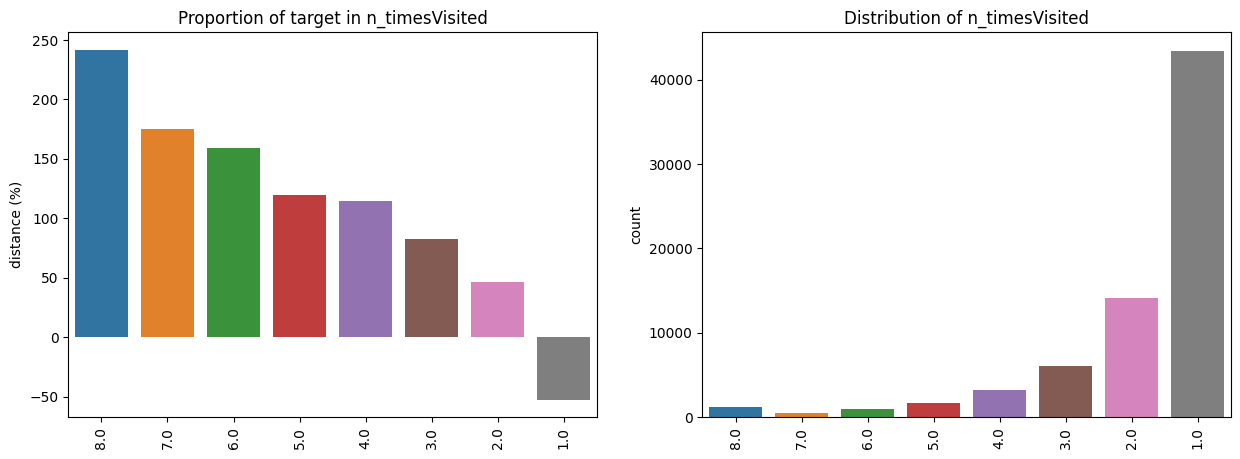

In [669]:
var_report('n_timesVisited', data)

In [668]:
# Clip to 8 
data['n_timesVisited'] = data['n_timesVisited'].clip(upper=8)

##### Readmitted before

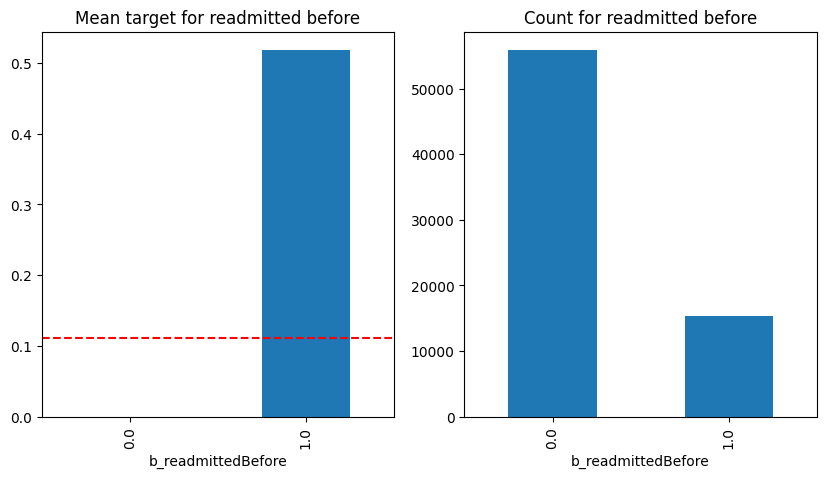

In [671]:
# Plot side by side the mean target and the count for the binary readmitted before variable
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
data.groupby('b_readmittedBefore')['b_target'].mean().plot.bar(ax=ax[0])
data.groupby('b_readmittedBefore')['b_target'].count().plot.bar(ax=ax[1])
# Plot an axhline for the mean target
ax[0].axhline(data['b_target'].mean(), color='red', linestyle='--')

ax[0].set_title('Mean target for readmitted before')
ax[1].set_title('Count for readmitted before')
plt.show()

### __Exporting the data__

In [687]:
test = data.loc[test_ids].drop(['b_target', 'c_target'], axis=1)
train = data.loc[train_ids]

# Export the data
train.to_csv('../Data/train_cleaned.csv')
test.to_csv('../Data/test_cleaned.csv')

In [688]:
train

,c_patient,b_gender,n_outvis,n_emvis,n_invis,n_stay,n_tests,n_nonLab,n_meds,n_diag,...,b_glu_missing,b_insulin,b_repaglinide,b_race_Asian,b_race_Caucasian,b_race_Hispanic,b_race_Other,n_timesVisited,b_readmittedBefore,n_readmittedPercentage
encounter_id,,,,,,,,,,,,,,,,,,,,,
524296,55629189,0.0,0.0,0.0,0.0,3.0,3.0,0.0,4.0,9.0,...,1,1,0,0,1,0,0,1.0,0.0,0.0
262154,82442376,1.0,0.0,0.0,0.0,2.0,2.0,1.0,3.0,7.0,...,1,1,0,0,1,0,0,1.0,0.0,0.0
524302,42519267,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,5.0,...,1,1,0,0,1,0,0,1.0,0.0,0.0
786457,84259809,1.0,0.0,0.0,0.0,4.0,4.0,1.0,4.0,7.0,...,1,1,0,0,1,0,0,1.0,0.0,0.0
262181,63555939,0.0,0.0,0.0,0.0,12.0,1.0,3.0,4.0,8.0,...,1,1,0,0,1,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262121,181593374,0.0,0.0,0.0,1.0,5.0,0.0,1.0,3.0,9.0,...,1,1,0,0,1,0,0,2.0,0.0,0.0
524272,50375628,0.0,3.0,1.0,2.0,6.0,2.0,1.0,5.0,9.0,...,1,1,0,0,0,0,0,6.0,0.0,0.0
524275,100162476,1.0,0.0,0.0,0.0,3.0,3.0,0.0,3.0,9.0,...,1,1,0,0,0,0,0,2.0,0.0,0.0
